# 1 - Importação das Bibliotecas

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from scipy import stats
from scipy.stats import binom, chisquare, skew
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import RandomOverSampler


# 2 - Importação da base de dados 

In [6]:
data = pd.read_csv('application_data.csv')

# Função para análise de desbalanceamento de dados
def analyze_dataset_balance(file_path):
    # Leitura do dataset
    df = pd.read_csv('application_data.csv')
    
    # Verificar se a coluna 'TARGET' existe
    if 'TARGET' not in df.columns:
        print("A coluna 'TARGET' não foi encontrada no dataset.")
        return
    
    # Contagem de transações fraudulentas e não fraudulentas
    count_target = df['TARGET'].value_counts()
    non_fraudulent = count_target[0]  # TARGET = 0
    fraudulent = count_target[1]      # TARGET = 1

    # Cálculo da proporção de cada classe
    total_transactions = non_fraudulent + fraudulent
    non_fraudulent_percentage = (non_fraudulent / total_transactions) * 100
    fraudulent_percentage = (fraudulent / total_transactions) * 100

    # Exibindo as contagens e proporções
    print(f"Total de transações não fraudulentas (TARGET = 0): {non_fraudulent}")
    print(f"Total de transações fraudulentas (TARGET = 1): {fraudulent}")
    print(f"Proporção de transações não fraudulentas: {non_fraudulent_percentage:.2f}%")
    print(f"Proporção de transações fraudulentas: {fraudulent_percentage:.2f}%")

    # Gráfico de barras para visualizar o desbalanceamento
    plt.figure(figsize=(8, 6))
    sns.barplot(x=count_target.index, y=count_target.values, palette='viridis')
    plt.title('Distribuição de Transações Fraudulentas vs Não Fraudulentas', fontsize=16)
    plt.xlabel('Classe de Transação', fontsize=14)
    plt.ylabel('Contagem', fontsize=14)
    plt.xticks([0, 1], ['Não Fraudulenta (0)', 'Fraudulenta (1)'])
    plt.show()

# Chamada da função passando o caminho do arquivo CSV
#file_path = 'seu_arquivo.csv'  # Substitua pelo caminho correto do seu arquivo
analyze_dataset_balance(file_path)

NameError: name 'file_path' is not defined

# 3 - EDA

- EDA: Análise dos dados e criação de novas colunas. Técnicas utilizadas: Análise das variáveis (numéricas e categóricas), identificação de valores ausentes, outliers, e relações entre variáveis (correlação, distribuições).

## 3.1 - Análise das variáveis (numéricas e categóricas)

In [28]:
# Função para identificar colunas numéricas e categóricas
def identificar_colunas(df):
    colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    colunas_categoricas = df.select_dtypes(include=['object']).columns.tolist()
    return colunas_numericas, colunas_categoricas

# Identificar colunas numéricas e categóricas
colunas_numericas, colunas_categoricas = identificar_colunas(data)
print("\nColunas numéricas:")
print(colunas_numericas)

print("\nColunas categóricas:")
print(colunas_categoricas)


Colunas numéricas:
['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLU

## 3.2 - Análise e Tratamento de dados nulos

In [32]:
def listar_colunas_com_nulos(df, porcentagem):
    # Calcula a porcentagem de valores nulos para cada coluna
    percentual_nulos = df.isnull().mean() * 100
    
    # Cria um DataFrame com o nome das colunas e a porcentagem de nulos
    informacao_nulos = pd.DataFrame({
        'Coluna': percentual_nulos.index,
        'Porcentagem de Nulos': percentual_nulos.values
    })
    
    # Filtra as colunas que têm mais de "porcentagem" de nulos
    colunas_acima_limite = informacao_nulos[informacao_nulos['Porcentagem de Nulos'] > porcentagem]
    
    # Exibe as colunas com mais de 13% de nulos
    print("\nColunas com mais de 13% de valores nulos:")
    print(colunas_acima_limite)
    return colunas_acima_limite['Coluna'].tolist()


In [34]:
def remover_colunas_com_nulos(df, porcentagem):
    # Obter a lista de colunas com mais de 13% de nulos
    colunas_para_remover = listar_colunas_com_nulos(df, porcentagem)
    
    # Remove as colunas com mais de 13% de nulos
    df_sem_colunas_nulas = df.drop(columns=colunas_para_remover)
    return df_sem_colunas_nulas


### 3.21 - Valores Nulos: Exclusão dos dados > 13% 

In [37]:
# Definindo a porcentagem limite (neste caso 13%)
porcentagem_limite = 13

# Criando um novo dataframe sem colunas com mais de 13% de nulos
df_sem_nulos = remover_colunas_com_nulos(data, porcentagem_limite)

# Exibindo o novo dataframe
print("\nNovo dataframe sem colunas com mais de 13% de nulos:")
print(df_sem_nulos.head())
print(f"Tamanho do novo dataframe: {df_sem_nulos.shape}")



Colunas com mais de 13% de valores nulos:
                           Coluna  Porcentagem de Nulos
21                    OWN_CAR_AGE             65.990810
28                OCCUPATION_TYPE             31.345545
41                   EXT_SOURCE_1             56.381073
43                   EXT_SOURCE_3             19.825307
44                 APARTMENTS_AVG             50.749729
45               BASEMENTAREA_AVG             58.515956
46    YEARS_BEGINEXPLUATATION_AVG             48.781019
47                YEARS_BUILD_AVG             66.497784
48                 COMMONAREA_AVG             69.872297
49                  ELEVATORS_AVG             53.295980
50                  ENTRANCES_AVG             50.348768
51                  FLOORSMAX_AVG             49.760822
52                  FLOORSMIN_AVG             67.848630
53                   LANDAREA_AVG             59.376738
54           LIVINGAPARTMENTS_AVG             68.354953
55                 LIVINGAREA_AVG             50.193326
56   

### 3.22 - Valores Nulos: Substituindo os remanescentes por mediana e moda

In [40]:
# Tratamento dos valores nulos 
colunas_numericas = ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2',
                                  'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                                  'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']
df_sem_nulos[colunas_numericas] = df_sem_nulos[colunas_numericas].fillna(df_sem_nulos[colunas_numericas].median())
df_sem_nulos['NAME_TYPE_SUITE'] = df_sem_nulos['NAME_TYPE_SUITE'].fillna(df_sem_nulos['NAME_TYPE_SUITE'].mode()[0])

## 3.3 - Feature Engineering

- Feature engineering: Transformação de variáveis, criação de novas variáveis derivadas como IDADE, ANOS TRABALHADOS, etc.

- Conversao de algumas colunas para anos

In [50]:
# Colunas que terão o sinal removido (valores absolutos)
colunas_para_remover_sinal = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
df_sem_nulos[colunas_para_remover_sinal] = df_sem_nulos[colunas_para_remover_sinal].abs()

# Engenharia de atributos
df_sem_nulos['IDADE'] = df_sem_nulos['DAYS_BIRTH'] // 365
df_sem_nulos['ANOS_TRABALHADOS'] = df_sem_nulos['DAYS_EMPLOYED'] // 365
df_sem_nulos['ANOS_REGISTRO'] = df_sem_nulos['DAYS_REGISTRATION'] // 365
df_sem_nulos['ANOS_PUBLICACAO_ID'] = df_sem_nulos['DAYS_ID_PUBLISH'] // 365

# Remover colunas originais
df_final = df_sem_nulos.drop(colunas_para_remover_sinal, axis=1)

- Coluna de Categorização - Recebimento de documentos: Esta coluna informa se a pessoa forneceu todos os documentos exigidos ou não, e exiba o número de documentos que ela enviou.

In [53]:
docs_colunas = ['FLAG_DOCUMENT_' + str(i) for i in range(2, 22)]
df_final['NUM_DOCS_APRESENTADOS'] = df_final[docs_colunas].sum(axis=1)
flag_docs_colunas = [col for col in df_final.columns if col.startswith('FLAG_DOCUMENT_')]
df_exclusao_cols = df_final.drop(columns=flag_docs_colunas)
df_final = df_exclusao_cols

- Exclusão dos valores 'XNA' (essencialmente nulos) na coluna GENERO

In [56]:
df_final = df_final[df_final['CODE_GENDER'] != 'XNA']

- Criação de algumas colunas do tipo 'DUMMIES' 

In [59]:
# Ajuste da base para o modelo estatistico
# Tratamento das colunas com valores categóricos 

# Coluna CODE_GENDER
df_dummies_gender = pd.get_dummies(df_final['CODE_GENDER'], prefix='CODE_GENDER')
df_final = pd.concat([df_final, df_dummies_gender], axis=1)
# add de 02 colunas

# Coluna FLAG_OWN_CAR
df_dummies_car = pd.get_dummies(df_final['FLAG_OWN_CAR'], prefix='FLAG_CAR')
df_final = pd.concat([df_final, df_dummies_car], axis=1)
# add de 02 colunas

# Coluna FLAG_OWN_REALTY
df_dummies_realty = pd.get_dummies(df_final['FLAG_OWN_REALTY'], prefix='FLAG_REALTY')
df_final = pd.concat([df_final, df_dummies_realty], axis=1)
# add de 02 colunas

# Coluna NAME_CONTRACT_TYPE
df_dummies_contract = pd.get_dummies(df_final['NAME_CONTRACT_TYPE'], prefix='CONTRACT_TYPE')
df_final = pd.concat([df_final, df_dummies_contract], axis=1)
# add de 02 colunas

#df_final.drop(columns=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_CONTRACT_TYPE'], inplace=True)

rename_dict = {
    'CONTRACT_TYPE_Cash loans': 'CONTRACT_TYPE_Cash',
    'CONTRACT_TYPE_Revolving loans': 'CONTRACT_TYPE_Revolving'
}

df_final.rename(columns=rename_dict, inplace=True)
#df_final.columns = df_final.columns.str.lower()

## 3.4 - Matriz de Correlação 

- Matriz de Correlação: Utilizando o método corr() do pandas para gerar uma matriz de correlação entre as colunas numéricas do dataframe.

- Mapa de Calor: Com seaborn, gera um mapa de calor para visualizar as correlações de maneira mais clara.

- Filtrar Correlações Altas: Filtre as correlações acima de um certo limite (geralmente > 0.9) para identificar colunas que são altamente similares.

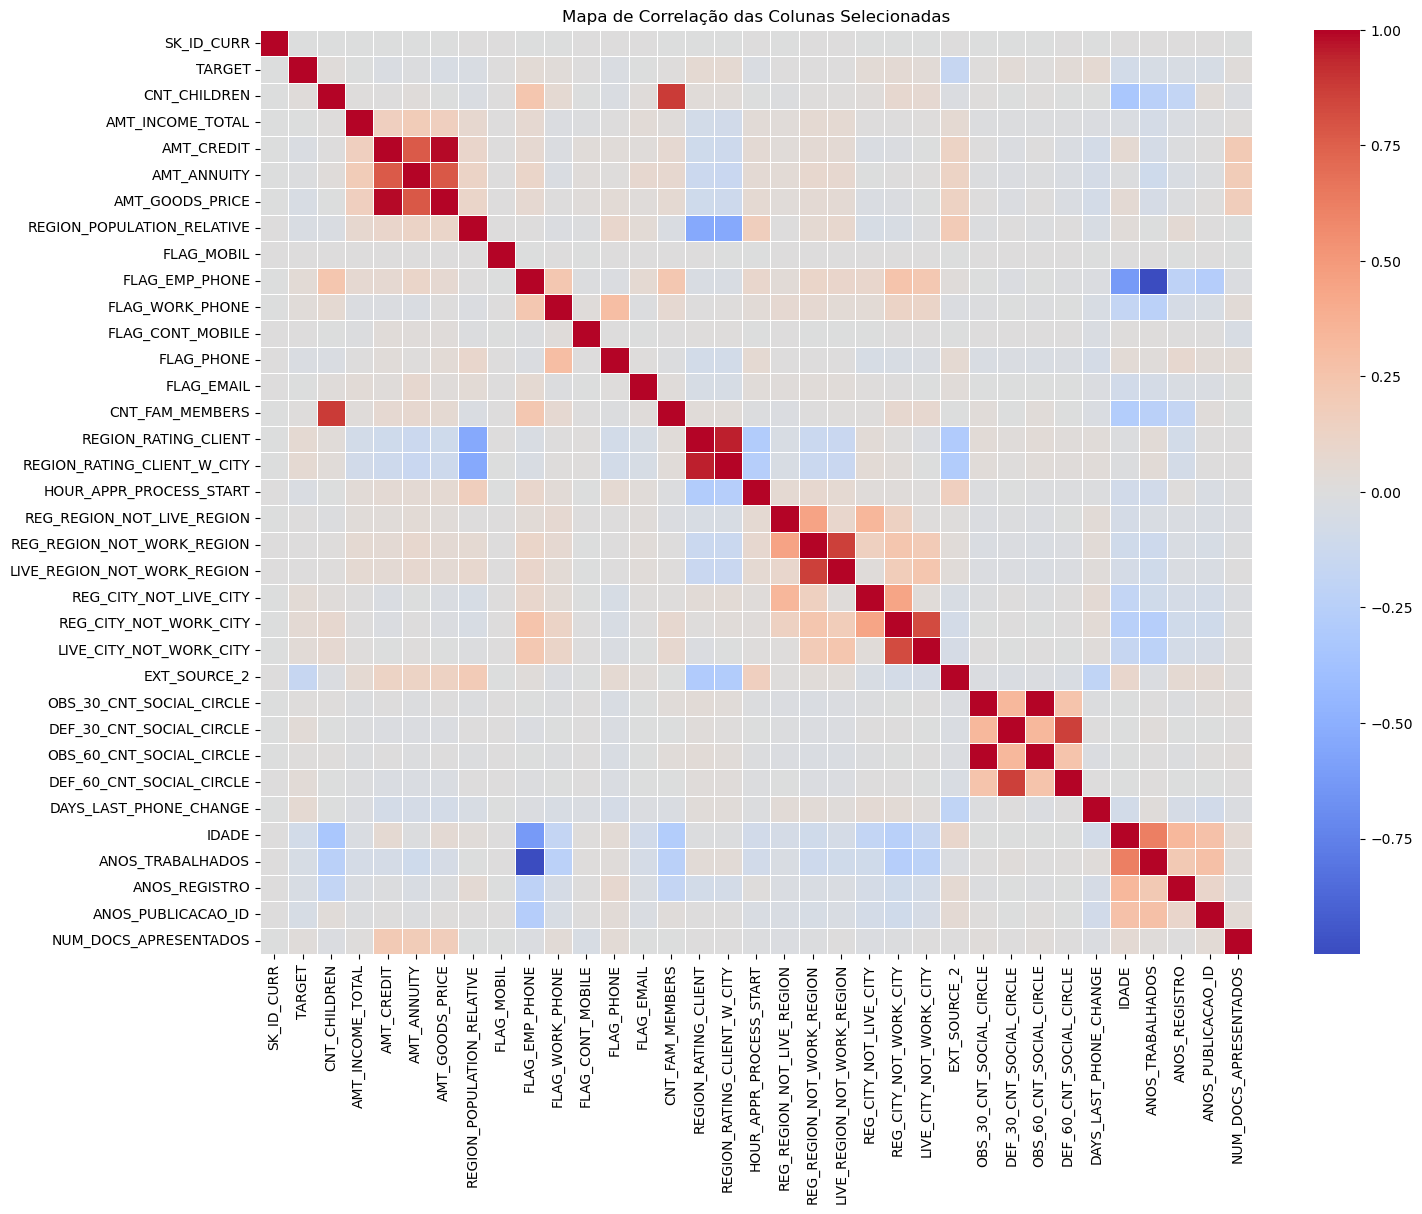

ANOS_TRABALHADOS          FLAG_EMP_PHONE                 0.999753
OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE       0.998491
AMT_GOODS_PRICE           AMT_CREDIT                     0.986736
REGION_RATING_CLIENT      REGION_RATING_CLIENT_W_CITY    0.950842
dtype: float64


In [64]:
colunas_numericas = df_final.select_dtypes(include=['int64', 'float64']).columns
df_matriz_corr = df_final[colunas_numericas]

# Gerar a matriz de correlação
correlation_matrix = df_matriz_corr.corr()

# Plotar o mapa de calor
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Correlação das Colunas Selecionadas')
plt.show()

# Filtrar pares de correlações maiores que 0.9
high_correlation_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs > 0.9) & (high_correlation_pairs < 1)]

# Exibir os pares mais correlacionados
print(high_correlation_pairs.head(10))

In [65]:
flag_cols_correl = ['ANOS_TRABALHADOS','OBS_30_CNT_SOCIAL_CIRCLE','AMT_GOODS_PRICE','REGION_RATING_CLIENT']
df_exclusao_cols = df_final.drop(columns=flag_cols_correl)
df_final = df_exclusao_cols

## 3.5 - Renomeando as colunas

In [69]:
novos_nomes_colunas = {
    'SK_ID_CURR': 'ID_CLIENTE',
    'CNT_CHILDREN': 'QTDE_FILHOS',
    'AMT_INCOME_TOTAL': 'RENDA_TOTAL',
    'AMT_CREDIT': 'VALOR_CREDITO',
    'AMT_ANNUITY': 'VALOR_ANUIDADE',
    'REGION_POPULATION_RELATIVE': 'POPULACAO_REGIAO_RELATIVA',
    'FLAG_MOBIL': 'FLAG_CELULAR',
    'FLAG_EMP_PHONE': 'FLAG_TEL_EMPRESA',
    'FLAG_WORK_PHONE': 'FLAG_TEL_TRABALHO',
    'FLAG_CONT_MOBILE': 'FLAG_CELULAR_CONTATO',
    'FLAG_PHONE': 'FLAG_TELEFONE',
    'FLAG_EMAIL': 'FLAG_EMAIL',
    'CNT_FAM_MEMBERS': 'QTDE_MEMBROS_FAMILIA',
    'REGION_RATING_CLIENT_W_CITY': 'AVALIACAO_REGIAO_CLIENTE_CIDADE',
    'HOUR_APPR_PROCESS_START': 'HORA_INICIO_PROCESSO',
    'REG_REGION_NOT_LIVE_REGION': 'REGIAO_NAO_RESIDE',
    'REG_REGION_NOT_WORK_REGION': 'REGIAO_NAO_TRABALHA',
    'LIVE_REGION_NOT_WORK_REGION': 'RESIDE_NAO_TRABALHA_REGIAO',
    'REG_CITY_NOT_LIVE_CITY': 'CIDADE_NAO_RESIDE',
    'REG_CITY_NOT_WORK_CITY': 'CIDADE_NAO_TRABALHA',
    'LIVE_CITY_NOT_WORK_CITY': 'RESIDE_NAO_TRABALHA_CIDADE',
    'EXT_SOURCE_2': 'FONTE_EXTERNA_2',
    'DEF_30_CNT_SOCIAL_CIRCLE': 'QTDE_DEF_30_CIRCULO_SOCIAL',
    'OBS_60_CNT_SOCIAL_CIRCLE': 'QTDE_OBS_60_CIRCULO_SOCIAL',
    'DEF_60_CNT_SOCIAL_CIRCLE': 'QTDE_DEF_60_CIRCULO_SOCIAL',
    'DAYS_LAST_PHONE_CHANGE': 'DIAS_ULTIMA_TROCA_TELEFONE',
    'CODE_GENDER': 'GENERO',
    'CODE_GENDER_F': 'GENERO_F',
    'CODE_GENDER_M': 'GENERO_M',
    'FLAG_OWN_CAR': 'POSSUI_CARRO',
    'FLAG_CAR_N': 'POSSUI_CARRO_N',
    'FLAG_CAR_Y': 'POSSUI_CARRO_S',
    'FLAG_OWN_REALTY': 'POSSUI_IMOVEL',
    'FLAG_REALTY_N': 'POSSUI_IMOVEL_N',
    'FLAG_REALTY_Y': 'POSSUI_IMOVEL_S',
    'NAME_CONTRACT_TYPE': 'TIPO_CONTRATO',
    'CONTRACT_TYPE_Cash': 'TIPO_CONTRATO_DINH',
    'CONTRACT_TYPE_Revolving': 'TIPO_CONTRATO_REVOG',
    'NAME_TYPE_SUITE': 'TIPO_SUITE',
    'NAME_INCOME_TYPE': 'TIPO_RENDA',
    'NAME_EDUCATION_TYPE': 'NIVEL_EDUCACAO',
    'NAME_FAMILY_STATUS': 'ESTADO_CIVIL',
    'NAME_HOUSING_TYPE': 'TIPO_MORADIA',
    'WEEKDAY_APPR_PROCESS_START': 'DIA_SEMANA_PROCESSO',
    'ORGANIZATION_TYPE': 'TIPO_ORGANIZACAO'
}

df_renomeado = df_final.rename(columns=novos_nomes_colunas)

## 3.6 - Relação das Variáveis em df_final

In [78]:
def identificar_colunas_formatado(df):
    colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    colunas_categoricas = df.select_dtypes(include=['object','bool']).columns.tolist()

    # Criar listas com as classificações e tipos
    classificacoes = ['Numérica' for _ in colunas_numericas] + ['Categórica' for _ in colunas_categoricas]
    tipos = [df[col].dtype for col in colunas_numericas] + [df[col].dtype for col in colunas_categoricas]

    # Criar DataFrame para exibição
    tabela_colunas = pd.DataFrame({
        'Coluna': colunas_numericas + colunas_categoricas,
        'Classificação': classificacoes,
        'Tipo': tipos
    })

    return tabela_colunas

# Identificar colunas numéricas e categóricas e formatar
tabela_colunas = identificar_colunas_formatado(df_renomeado)

# Exibir a tabela formatada
print(tabela_colunas)

                             Coluna Classificação     Tipo
0                        ID_CLIENTE      Numérica    int64
1                            TARGET      Numérica    int64
2                       QTDE_FILHOS      Numérica    int64
3                       RENDA_TOTAL      Numérica  float64
4                     VALOR_CREDITO      Numérica  float64
5                    VALOR_ANUIDADE      Numérica  float64
6         POPULACAO_REGIAO_RELATIVA      Numérica  float64
7                      FLAG_CELULAR      Numérica    int64
8                  FLAG_TEL_EMPRESA      Numérica    int64
9                 FLAG_TEL_TRABALHO      Numérica    int64
10             FLAG_CELULAR_CONTATO      Numérica    int64
11                    FLAG_TELEFONE      Numérica    int64
12                       FLAG_EMAIL      Numérica    int64
13             QTDE_MEMBROS_FAMILIA      Numérica  float64
14  AVALIACAO_REGIAO_CLIENTE_CIDADE      Numérica    int64
15             HORA_INICIO_PROCESSO      Numérica    int

Tabela 01: Visão Geral das Variaveis Categoricas e Numeéricas

| Variáveis                                                                                                         | Tipo        | Formato       |
|-------------------------------------------------------------------------------------------------------------------|-------------|---------------|
| ID_CLIENTE, TARGET, QTDE_FILHOS, FLAG_CELULAR, FLAG_TEL_EMPRESA, FLAG_TEL_TRABALHO, FLAG_CELULAR_CONTATO, FLAG_TELEFONE, FLAG_EMAIL, AVALIACAO_REGIAO_CLIENTE_CIDADE, HORA_INICIO_PROCESSO, REGIAO_NAO_RESIDE, REGIAO_NAO_TRABALHA, CIDADE_NAO_RESIDE, CIDADE_NAO_TRABALHA, IDADE, ANOS_PUBLICACAO_ID, NUM_DOCS_APRESENTADOS | Numérica    | int64         |
| RENDA_TOTAL, VALOR_CREDITO, VALOR_ANUIDADE, POPULACAO_REGIAO_RELATIVA, QTDE_MEMBROS_FAMILIA, FONTE_EXTERNA_2, QTDE_DEF_30_CIRCULO_SOCIAL, QTDE_OBS_60_CIRCULO_SOCIAL, QTDE_DEF_60_CIRCULO_SOCIAL, DIAS_ULTIMA_TROCA_TELEFONE, ANOS_REGISTRO | Numérica    | float64       |
| TIPO_CONTRATO, GENERO, POSSUI_CARRO, POSSUI_IMOVEL, TIPO_SUITE, TIPO_RENDA, NIVEL_EDUCACAO, ESTADO_CIVIL, TIPO_MORADIA, DIA_SEMANA_PROCESSO, TIPO_ORGANIZACAO | Categórica  | object        |
| GENERO_F, GENERO_M, POSSUI_CARRO_N, POSSUI_CARRO_S, POSSUI_IMOVEL_N, POSSUI_IMOVEL_S, TIPO_CONTRATO_DINH, TIPO_CONTRATO_REVOG | Categórica  | bool          |   |


# 4 - Análises Estatísticas

- Análises Estatísticas: Análises das variáveis numéricas (média, desvio-padrão, distribuição) e categóricas (frequência de classes). Uso de Tabelas: Exibir os principais resultados como a média e mediana das variáveis numéricas. Uso de Gráficos: Histogramas para variáveis contínuas, gráficos de barras para categóricas. Estrutura: Faça uma tabela ou gráfico para cada categoria de variável e explique os principais insights.

In [87]:
def calcular_metricas_numericas(df, colunas_numericas):
    metricas = {}
    for coluna in colunas_numericas:
        dados = df[coluna]
        metricas[coluna] = {
            'Média': dados.mean(),
            'Mediana': dados.median(),
            'Desvio Padrão': dados.std(),
            'Variância': dados.var(),
            'Mínimo': dados.min(),
            'Máximo': dados.max(),
            '1º Quartil': dados.quantile(0.25),
            '3º Quartil': dados.quantile(0.75),
            'IQR': dados.quantile(0.75) - dados.quantile(0.25),
            'Skewness': dados.skew(),
            'Kurtosis': dados.kurtosis()
        }
    return pd.DataFrame(metricas)

colunas_numericas = df_renomeado.select_dtypes(include=['int64', 'float64']).columns
metricas_numericas = calcular_metricas_numericas(df_renomeado, colunas_numericas)
print(metricas_numericas)

                 ID_CLIENTE    TARGET  QTDE_FILHOS   RENDA_TOTAL  \
Média          2.781815e+05  0.080730     0.417047  1.687977e+05   
Mediana        2.782030e+05  0.000000     0.000000  1.471500e+05   
Desvio Padrão  1.027901e+05  0.272420     0.722119  2.371246e+05   
Variância      1.056581e+10  0.074213     0.521456  5.622809e+10   
Mínimo         1.000020e+05  0.000000     0.000000  2.565000e+04   
Máximo         4.562550e+05  1.000000    19.000000  1.170000e+08   
1º Quartil     1.891465e+05  0.000000     0.000000  1.125000e+05   
3º Quartil     3.671435e+05  0.000000     1.000000  2.025000e+05   
IQR            1.779970e+05  0.000000     1.000000  9.000000e+04   
Skewness      -1.213482e-03  3.078133     1.974634  3.915574e+02   
Kurtosis      -1.198982e+00  7.474950     7.904369  1.917843e+05   

               VALOR_CREDITO  VALOR_ANUIDADE  POPULACAO_REGIAO_RELATIVA  \
Média           5.990286e+05    2.710858e+04                   0.020868   
Mediana         5.135310e+05    2

## 4.2 - Métricas Estatísticas: Colunas Categóricas

Para variáveis categóricas, calcula-se:

- Contagem de Ocorrências: Número de observações para cada categoria.
- Proporção: Percentual de cada categoria em relação ao total.
- Distribuição: Gráficos para visualizar a distribuição de categorias.


TIPO_CONTRATO
Contagem:
TIPO_CONTRATO
Cash loans         278232
Revolving loans     29275
Name: count, dtype: int64
Proporção (%):
TIPO_CONTRATO
Cash loans         90.479892
Revolving loans     9.520108
Name: proportion, dtype: float64


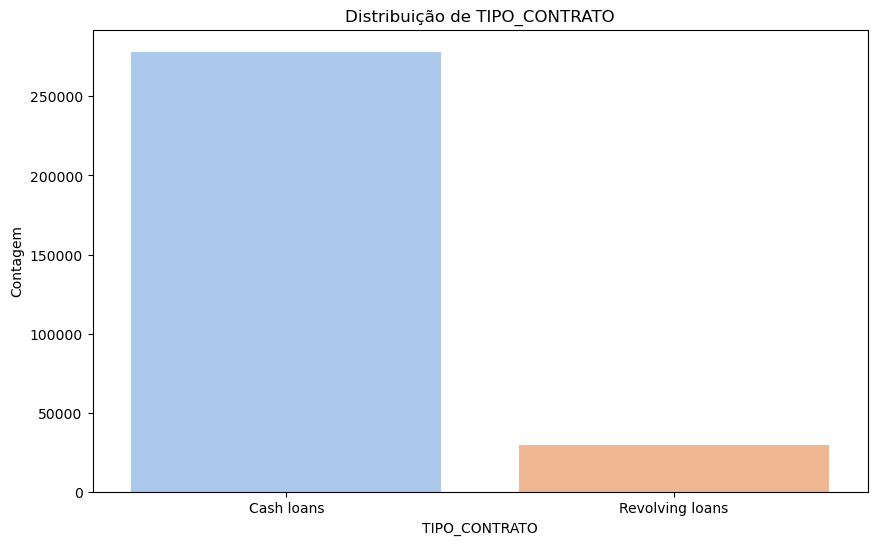


GENERO
Contagem:
GENERO
F    202448
M    105059
Name: count, dtype: int64
Proporção (%):
GENERO
F    65.835249
M    34.164751
Name: proportion, dtype: float64


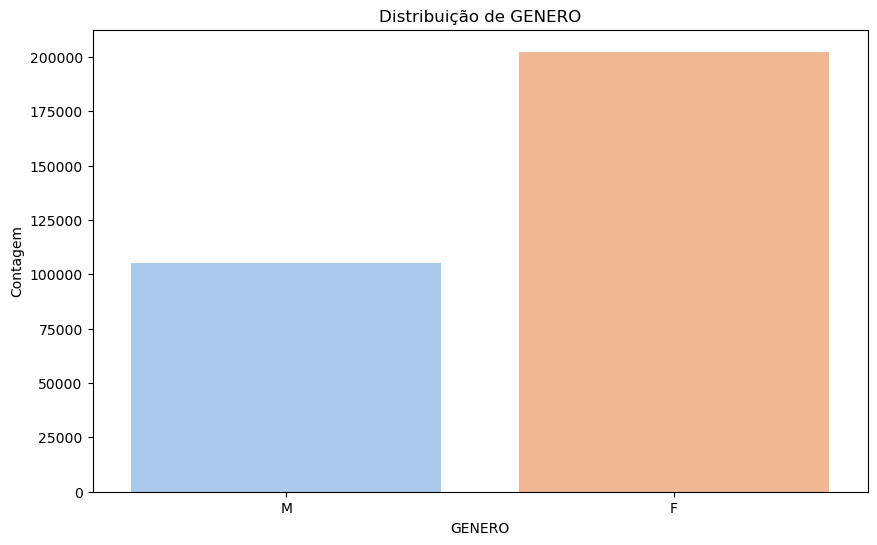


POSSUI_CARRO
Contagem:
POSSUI_CARRO
N    202922
Y    104585
Name: count, dtype: int64
Proporção (%):
POSSUI_CARRO
N    65.989392
Y    34.010608
Name: proportion, dtype: float64


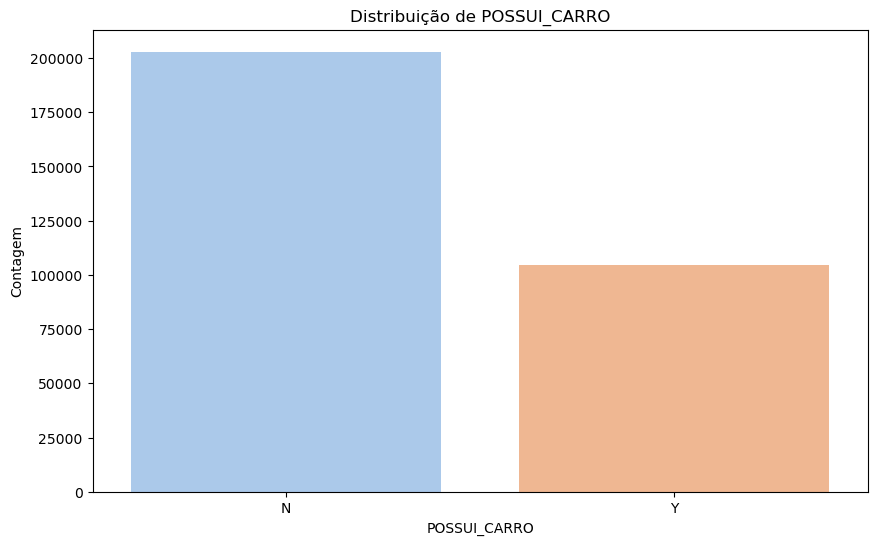


POSSUI_IMOVEL
Contagem:
POSSUI_IMOVEL
Y    213308
N     94199
Name: count, dtype: int64
Proporção (%):
POSSUI_IMOVEL
Y    69.366876
N    30.633124
Name: proportion, dtype: float64


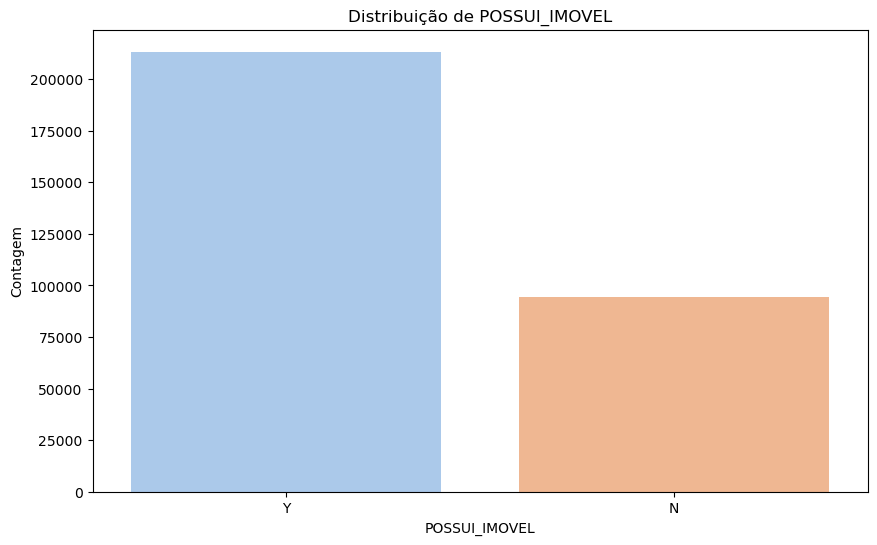


TIPO_SUITE
Contagem:
TIPO_SUITE
Unaccompanied      249815
Family              40148
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64
Proporção (%):
TIPO_SUITE
Unaccompanied      81.238801
Family             13.055963
Spouse, partner     3.697477
Children            1.062415
Other_B             0.575597
Other_A             0.281620
Group of people     0.088128
Name: proportion, dtype: float64


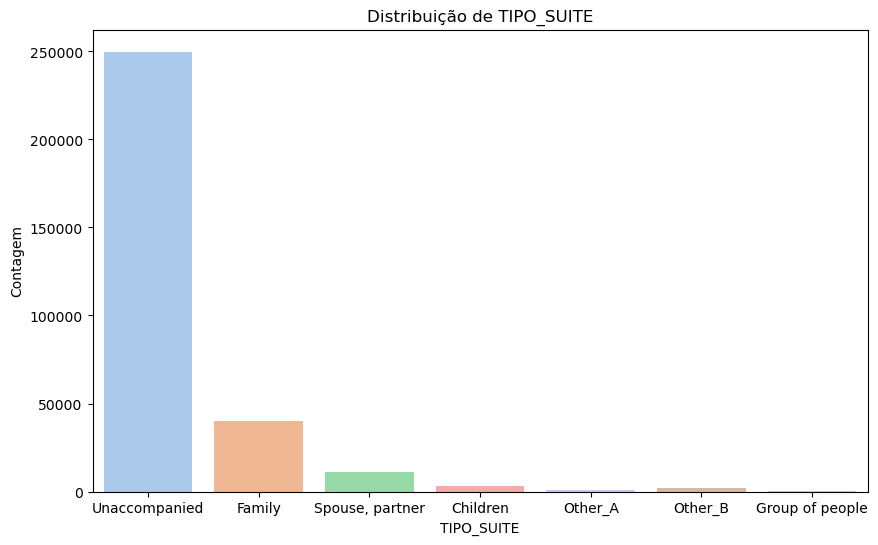


TIPO_RENDA
Contagem:
TIPO_RENDA
Working                 158771
Commercial associate     71616
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64
Proporção (%):
TIPO_RENDA
Working                 51.631670
Commercial associate    23.289226
Pensioner               18.003493
State servant            7.057726
Unemployed               0.007154
Student                  0.005854
Businessman              0.003252
Maternity leave          0.001626
Name: proportion, dtype: float64


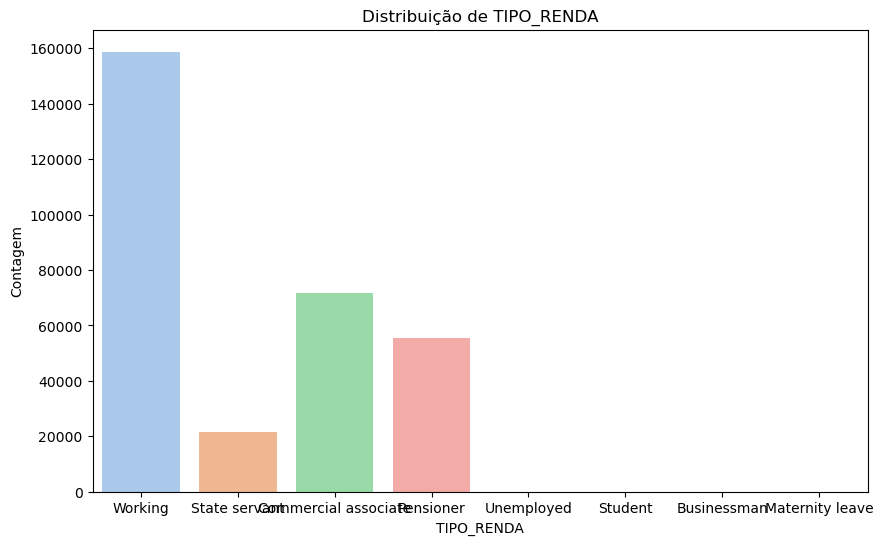


NIVEL_EDUCACAO
Contagem:
NIVEL_EDUCACAO
Secondary / secondary special    218389
Higher education                  74862
Incomplete higher                 10276
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64
Proporção (%):
NIVEL_EDUCACAO
Secondary / secondary special    71.019196
Higher education                 24.344812
Incomplete higher                 3.341713
Lower secondary                   1.240947
Academic degree                   0.053332
Name: proportion, dtype: float64


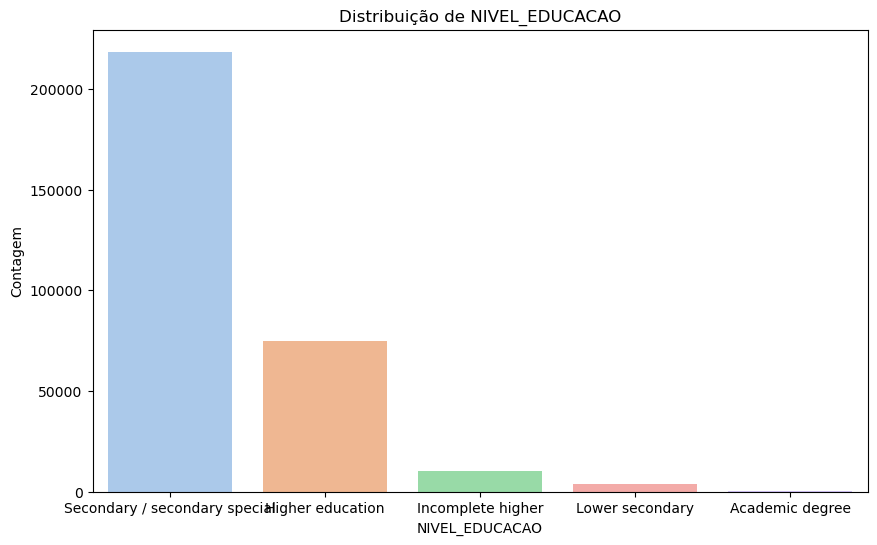


ESTADO_CIVIL
Contagem:
ESTADO_CIVIL
Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64
Proporção (%):
ESTADO_CIVIL
Married                 63.877895
Single / not married    14.778200
Civil marriage           9.682381
Separated                6.429122
Widow                    5.231751
Unknown                  0.000650
Name: proportion, dtype: float64


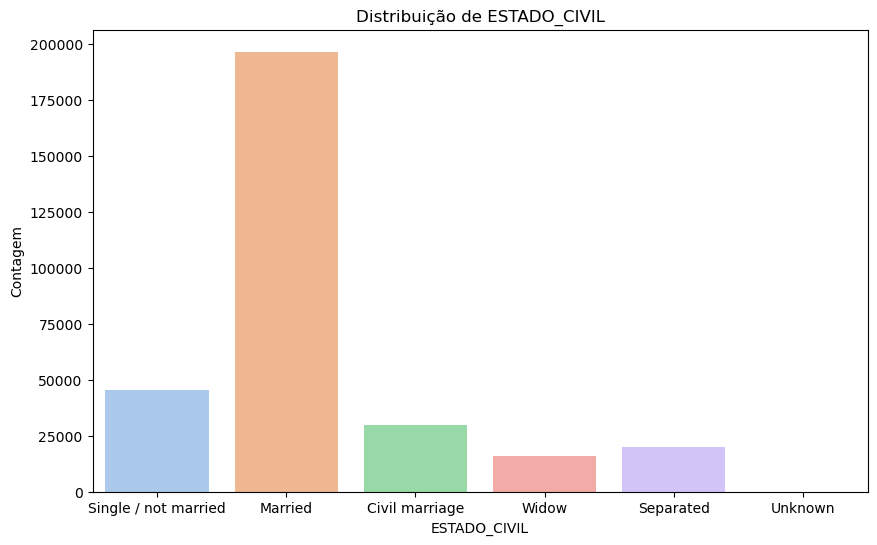


TIPO_MORADIA
Contagem:
TIPO_MORADIA
House / apartment      272865
With parents            14840
Municipal apartment     11182
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64
Proporção (%):
TIPO_MORADIA
House / apartment      88.734565
With parents            4.825906
Municipal apartment     3.636340
Rented apartment        1.587281
Office apartment        0.851038
Co-op apartment         0.364870
Name: proportion, dtype: float64


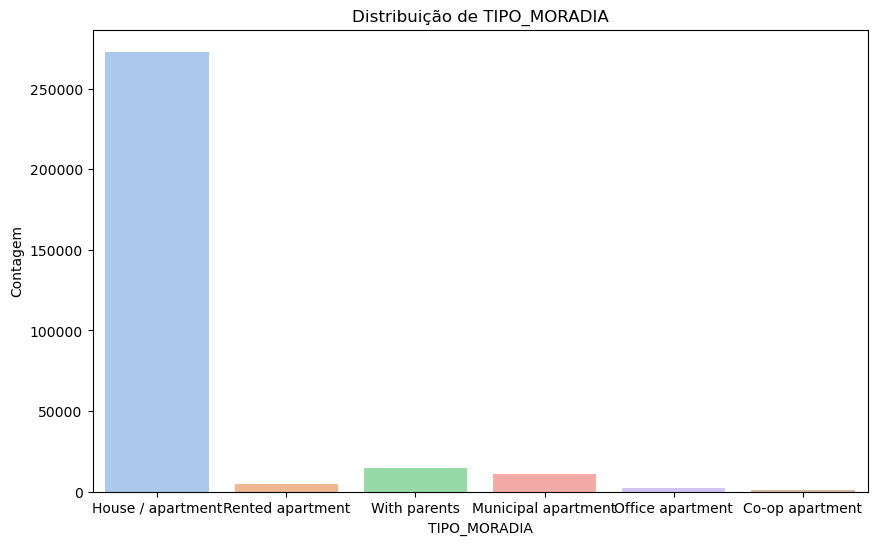


DIA_SEMANA_PROCESSO
Contagem:
DIA_SEMANA_PROCESSO
TUESDAY      53900
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50590
FRIDAY       50336
SATURDAY     33852
SUNDAY       16181
Name: count, dtype: int64
Proporção (%):
DIA_SEMANA_PROCESSO
TUESDAY      17.528056
WEDNESDAY    16.888721
MONDAY       16.491982
THURSDAY     16.451658
FRIDAY       16.369058
SATURDAY     11.008530
SUNDAY        5.261994
Name: proportion, dtype: float64


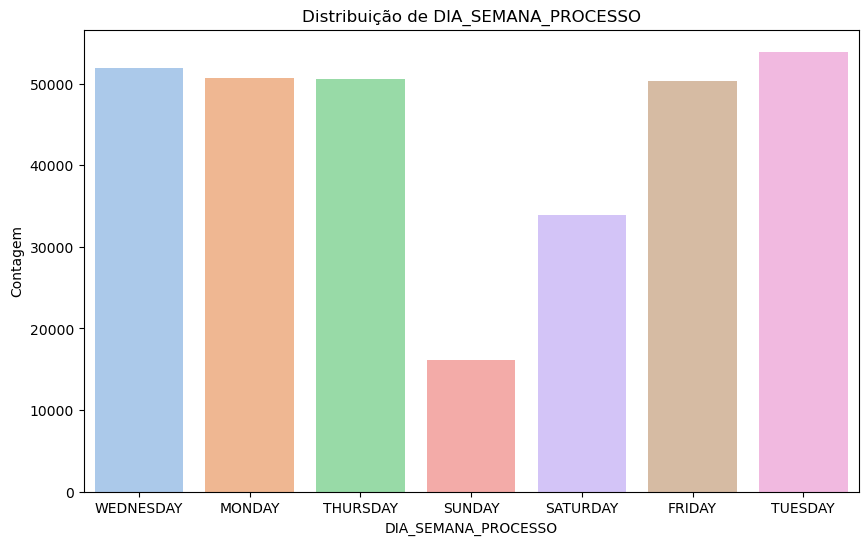


TIPO_ORGANIZACAO
Contagem:
TIPO_ORGANIZACAO
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 

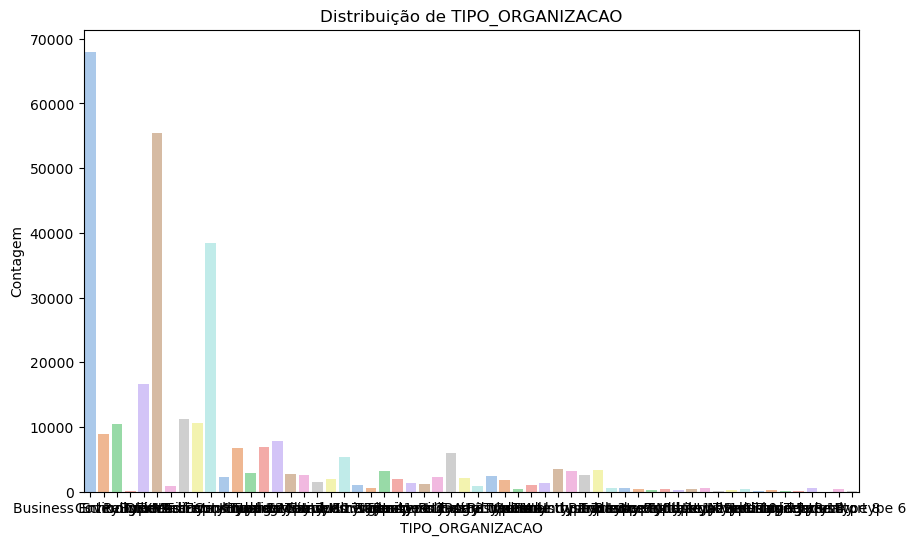

In [91]:
def analisar_variaveis_categoricas(df, colunas_categoricas):
    for coluna in colunas_categoricas:
        contagem = df[coluna].value_counts()
        proporcao = df[coluna].value_counts(normalize=True) * 100
        
        print(f'\n{coluna}')
        print(f'Contagem:\n{contagem}')
        print(f'Proporção (%):\n{proporcao}')

        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=coluna, palette='pastel')
        plt.title(f'Distribuição de {coluna}')
        plt.xlabel(coluna)
        plt.ylabel('Contagem')
        plt.show()

colunas_categoricas = df_renomeado.select_dtypes(include=['object', 'category']).columns
analisar_variaveis_categoricas(df_renomeado, colunas_categoricas)


## 4.3 - Distribuição das variáveis numéricas

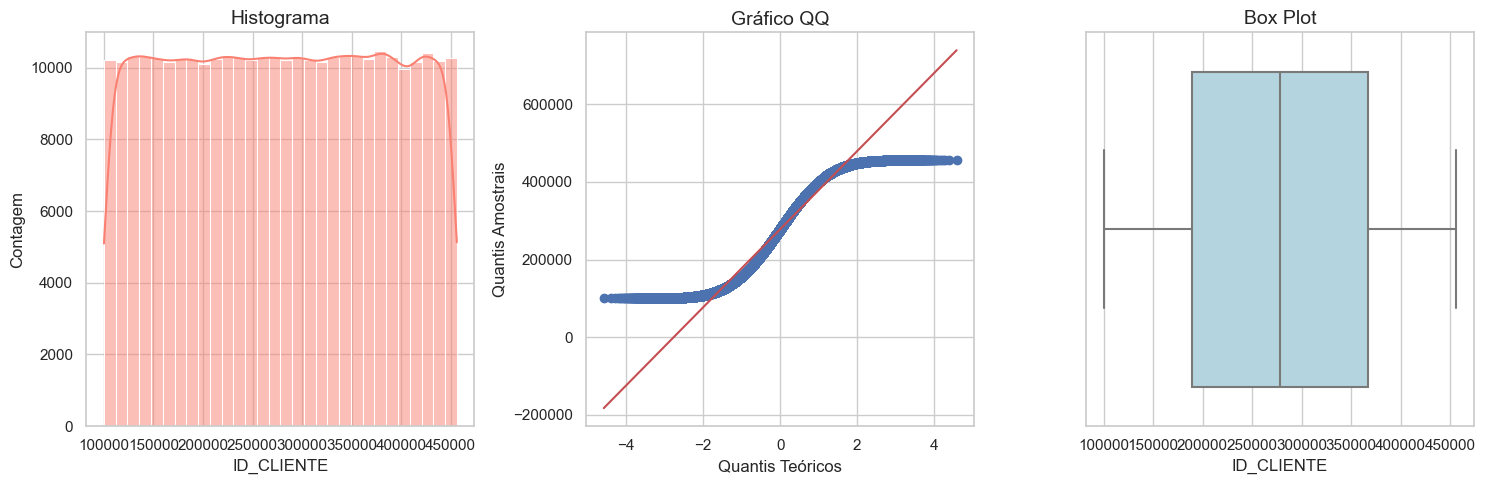

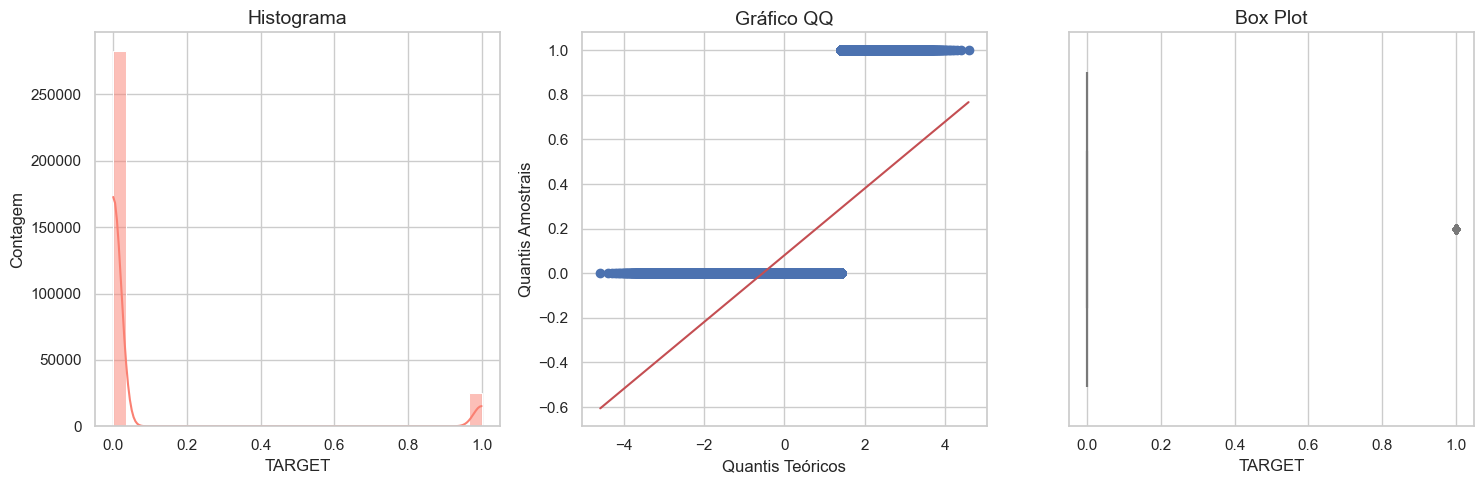

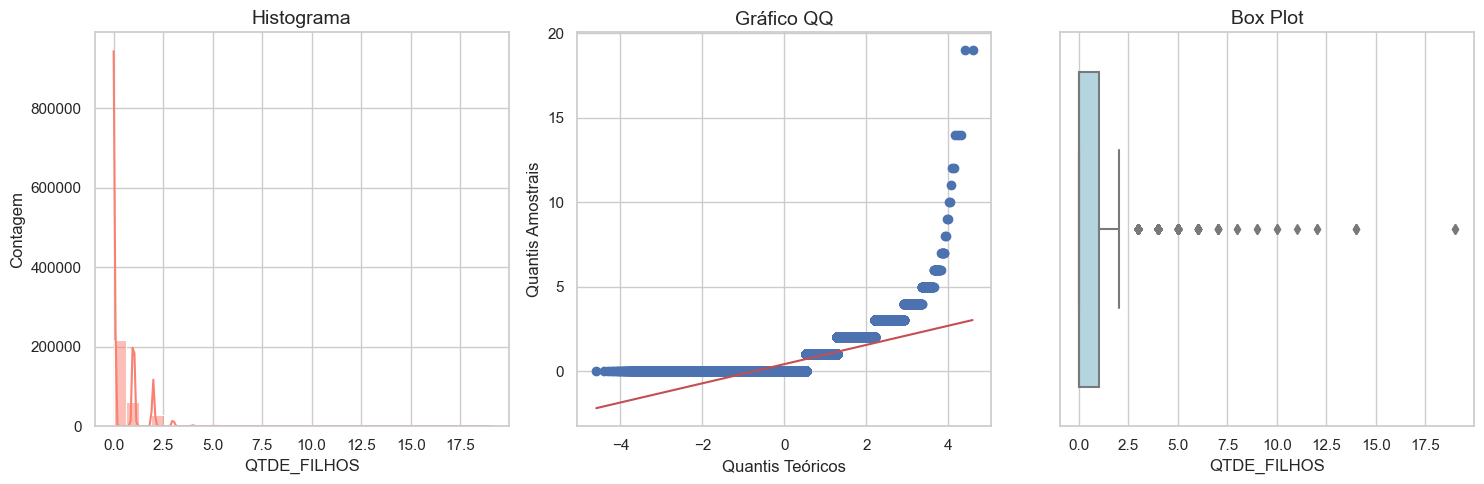

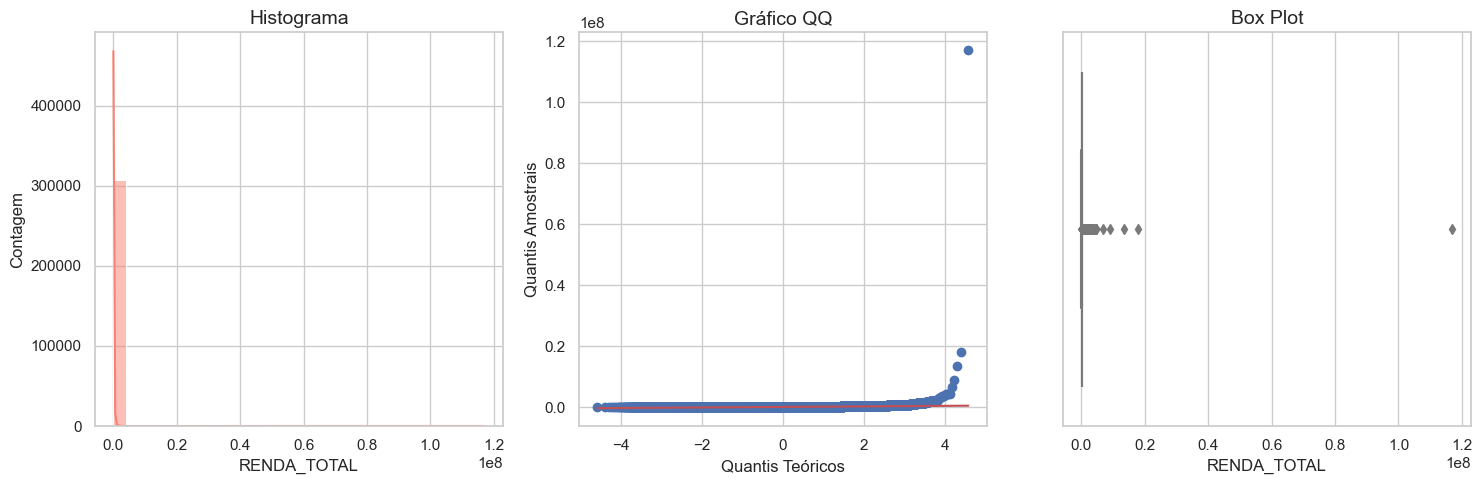

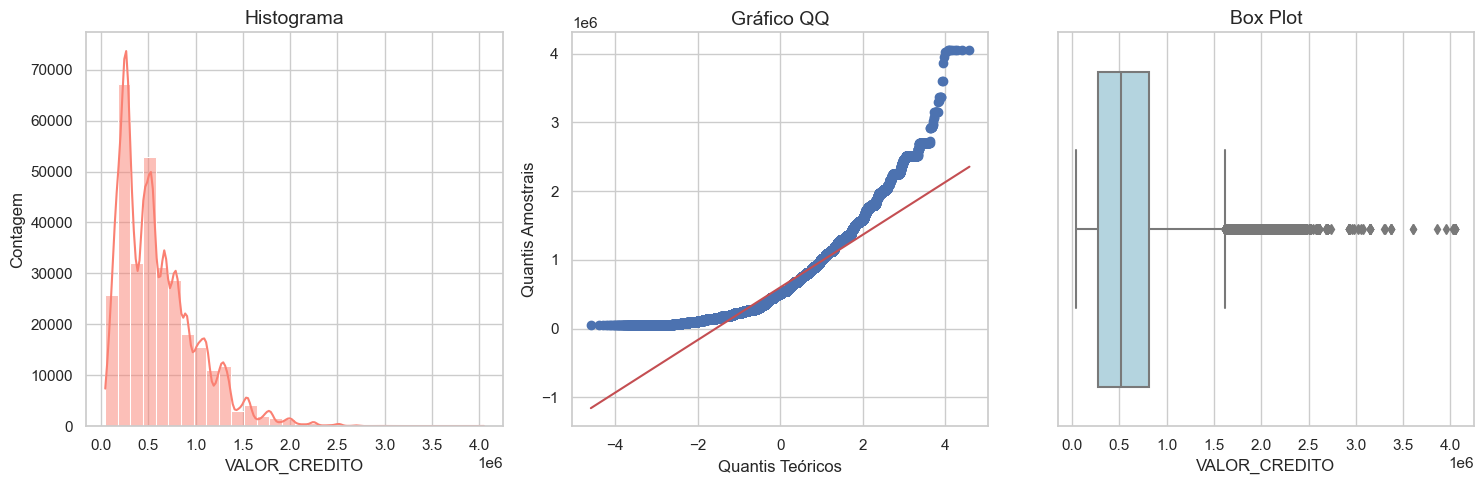

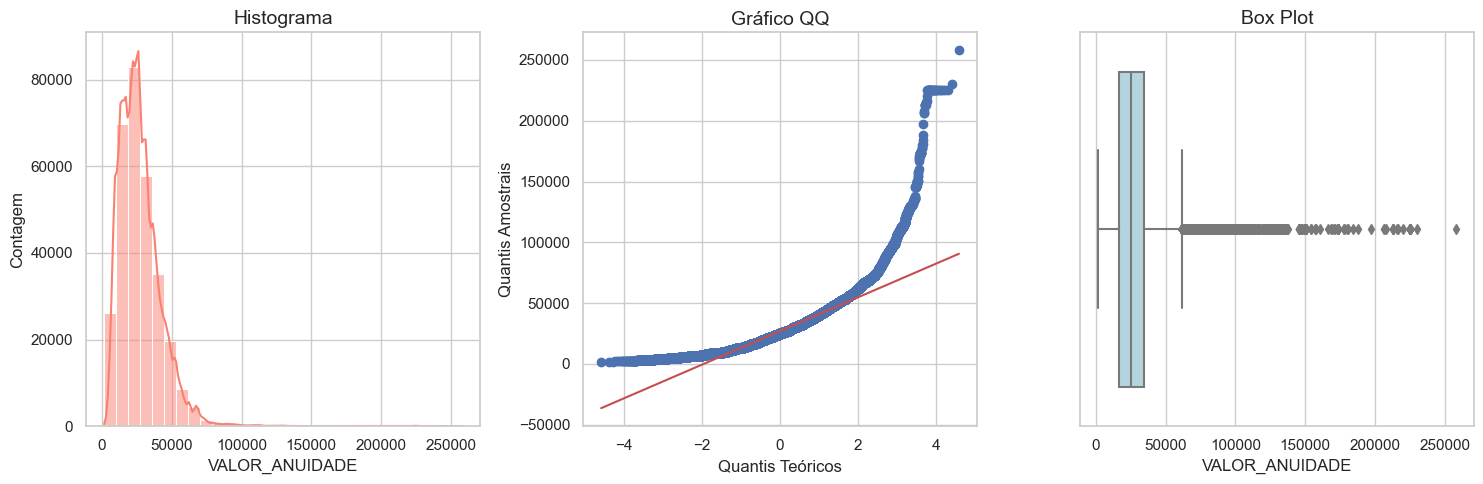

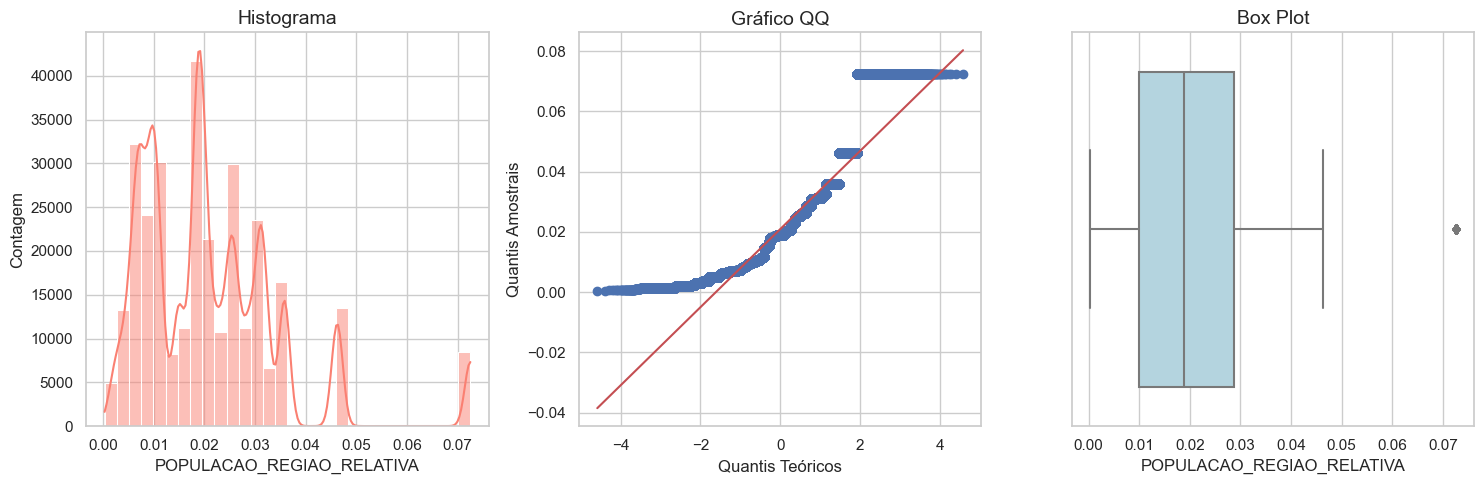

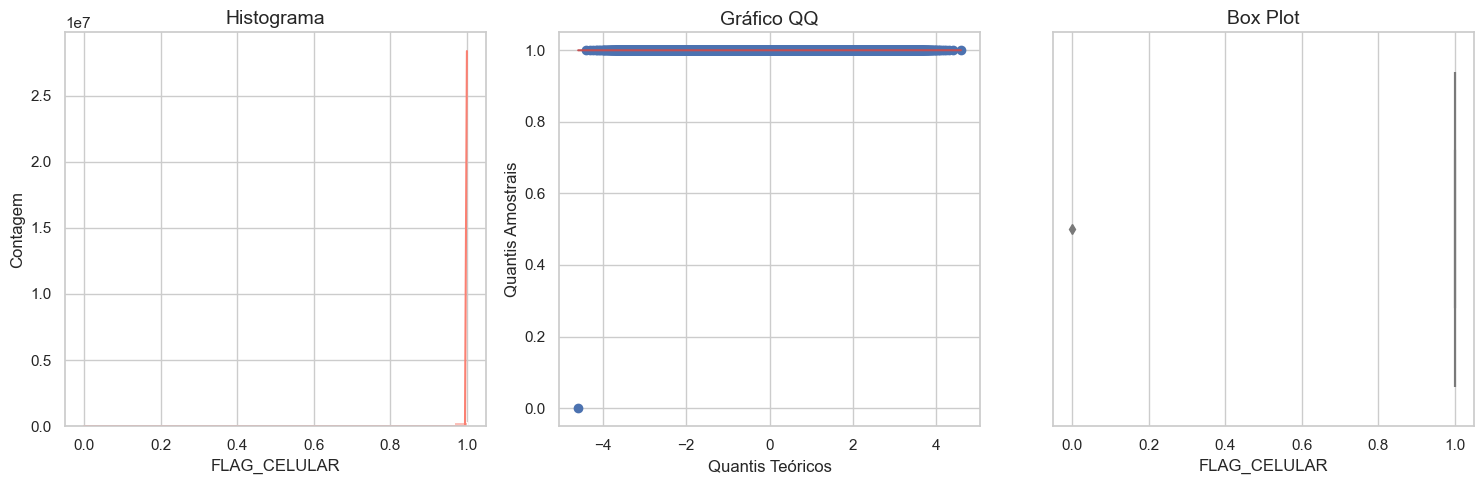

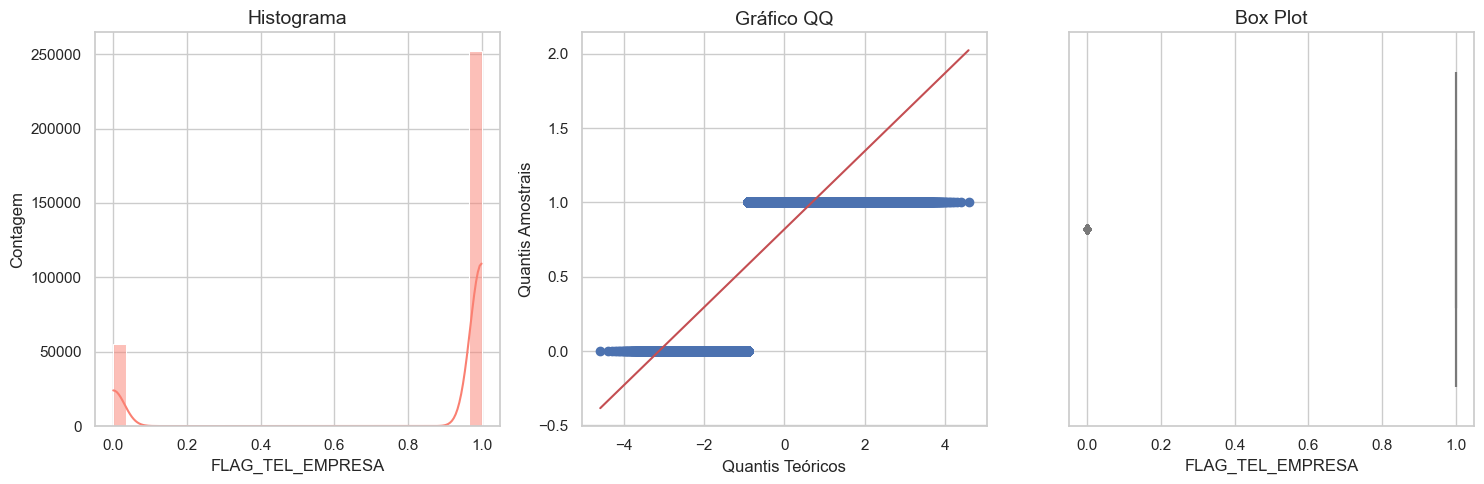

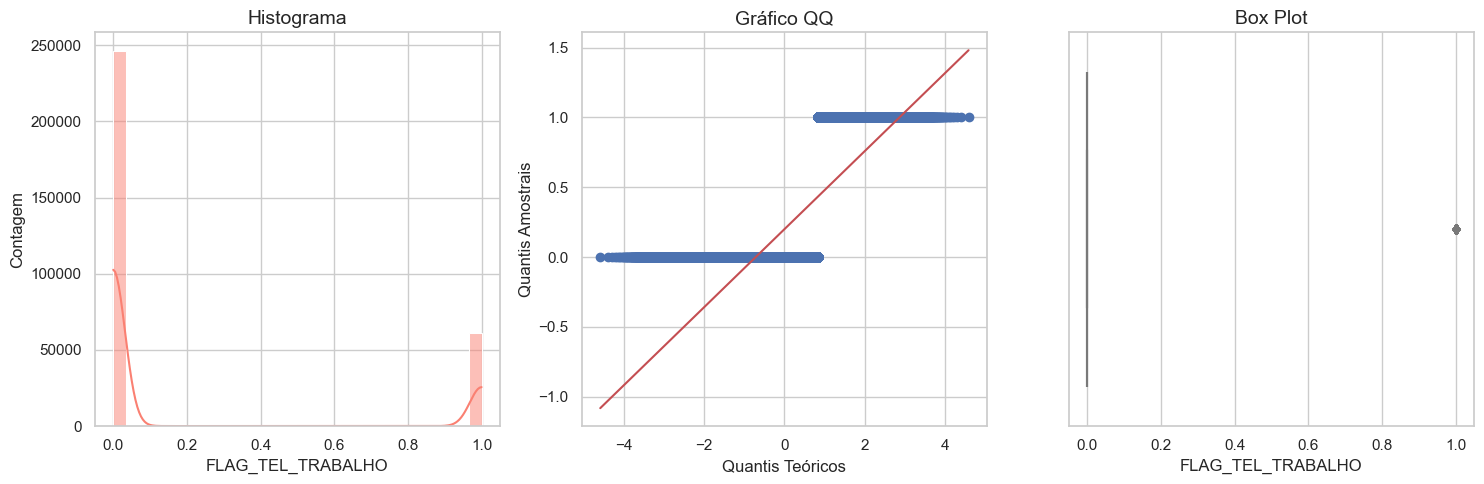

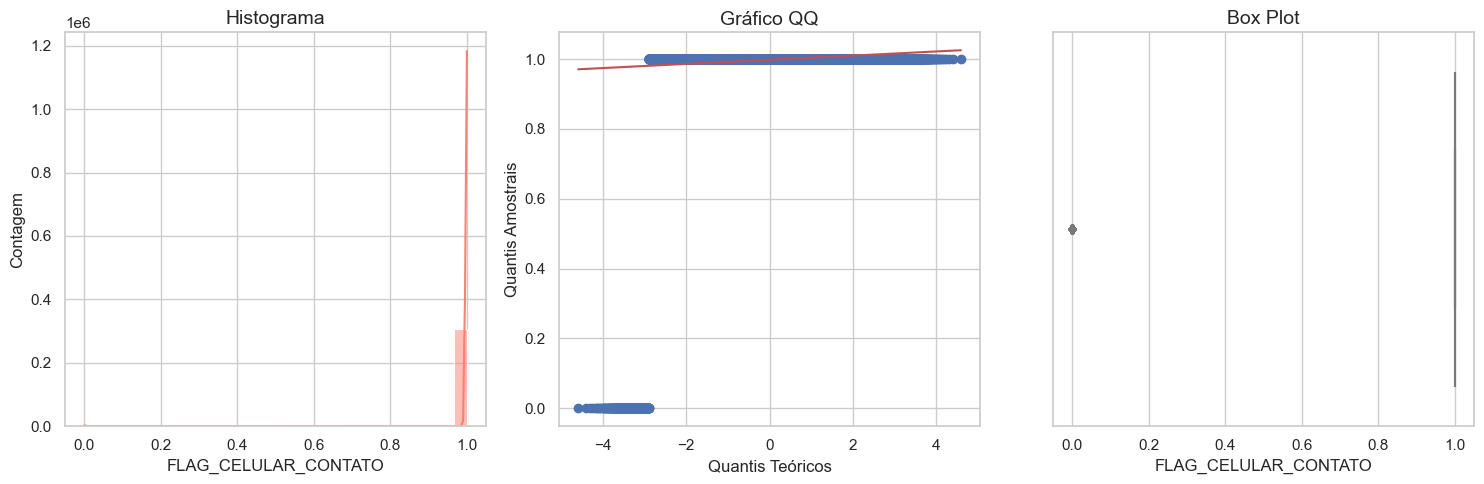

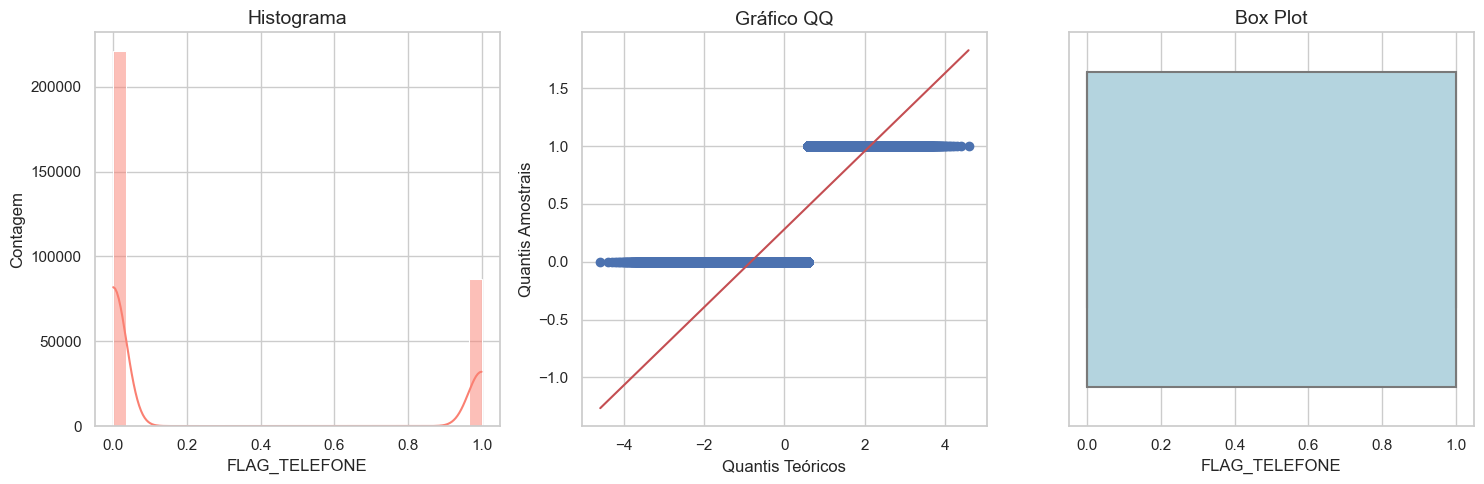

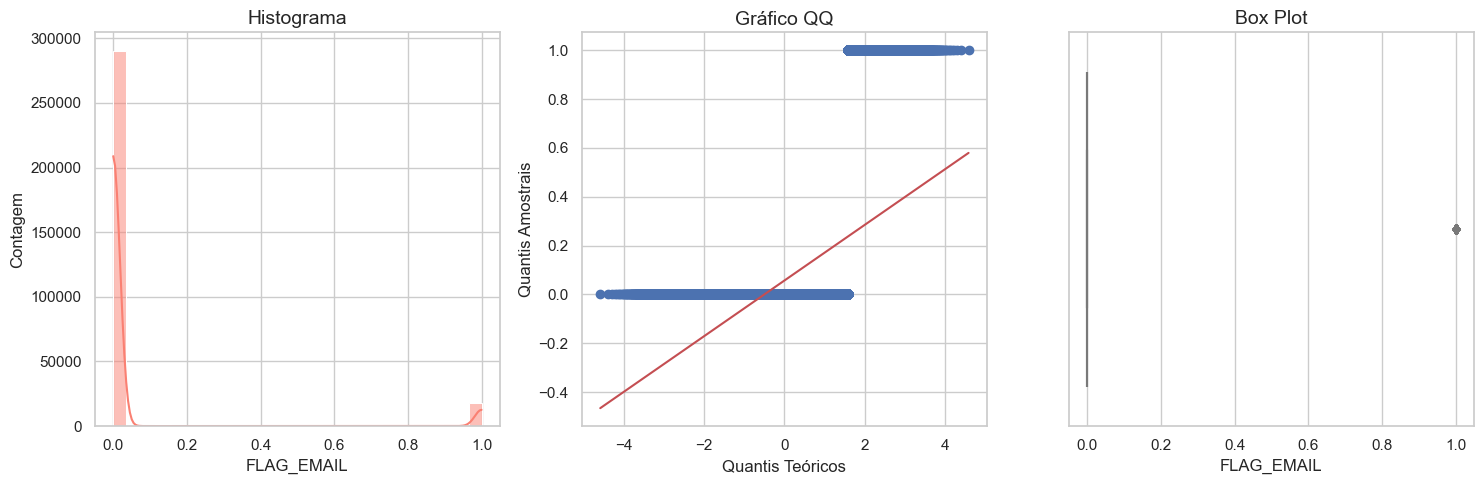

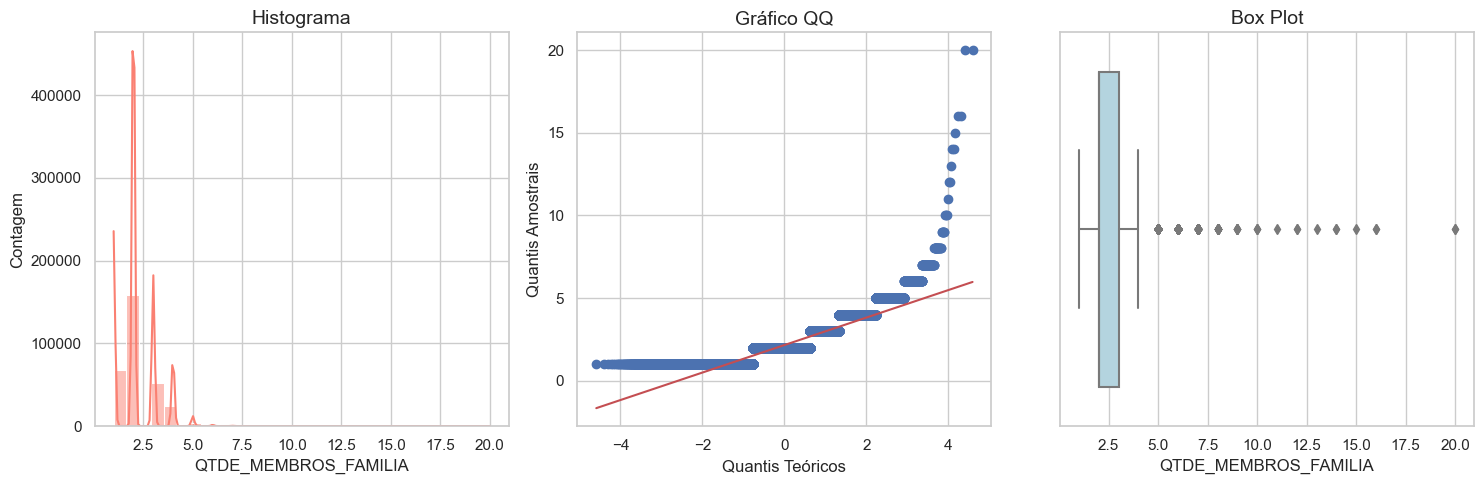

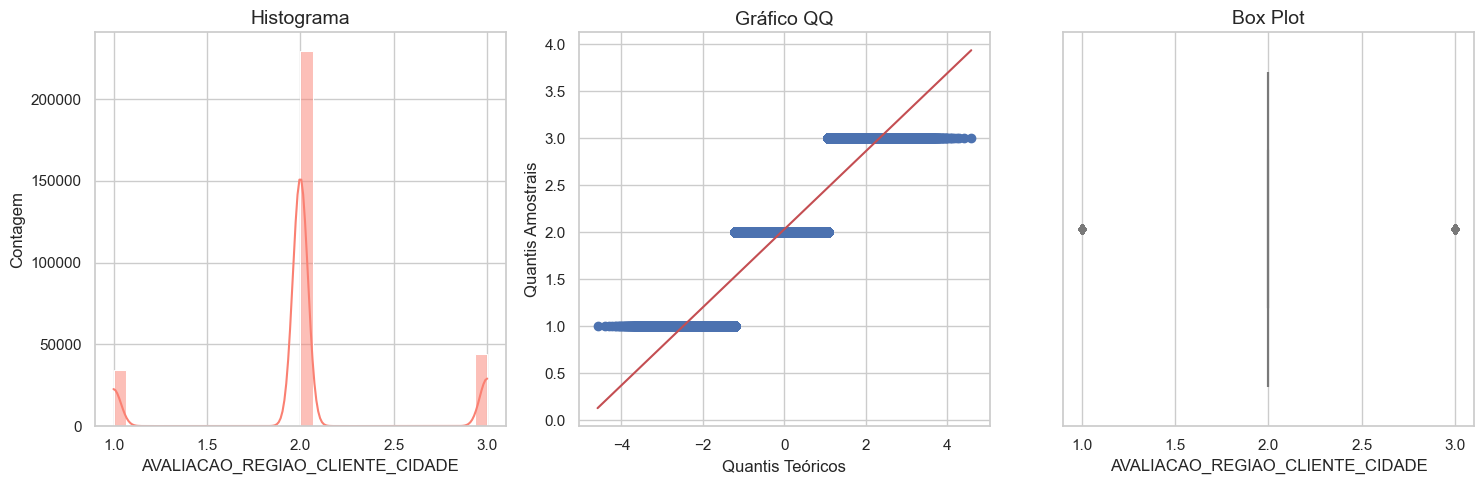

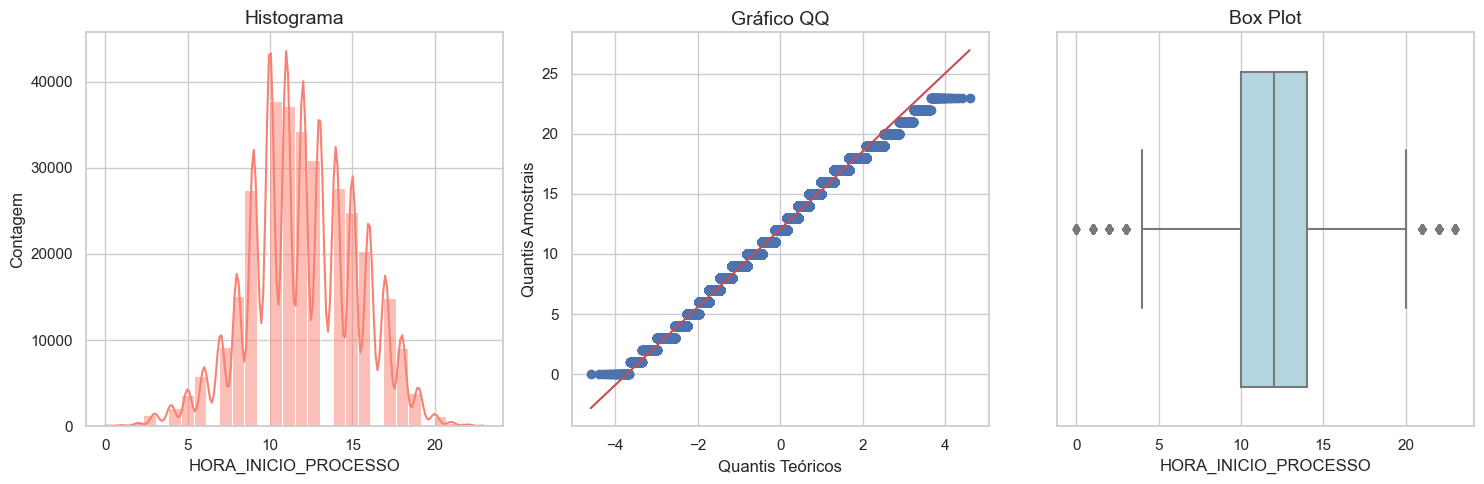

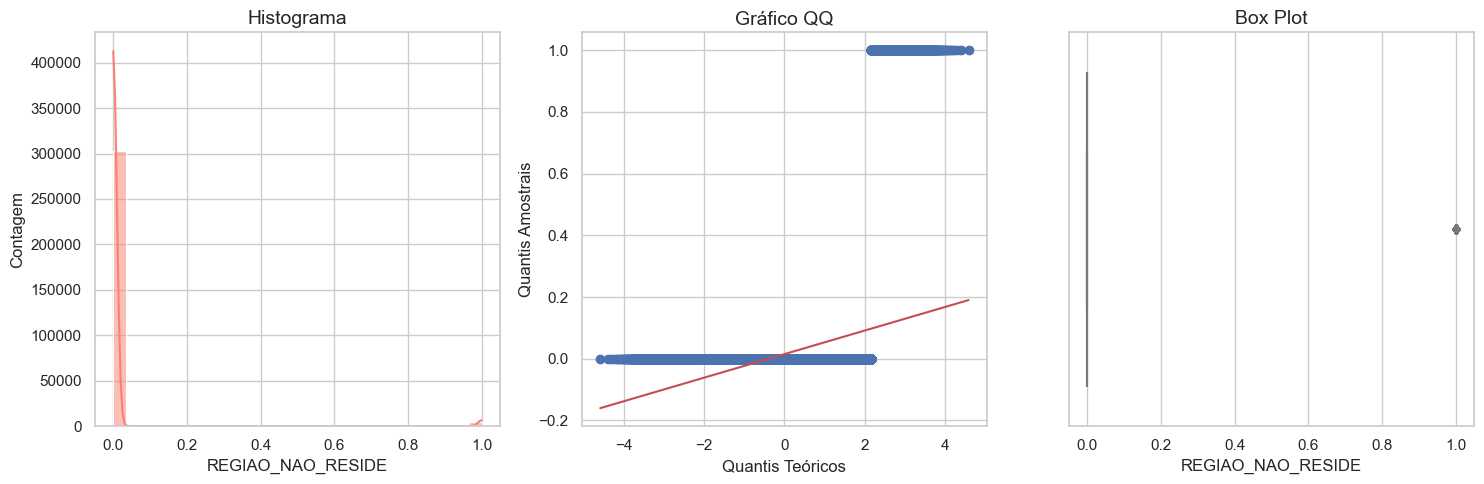

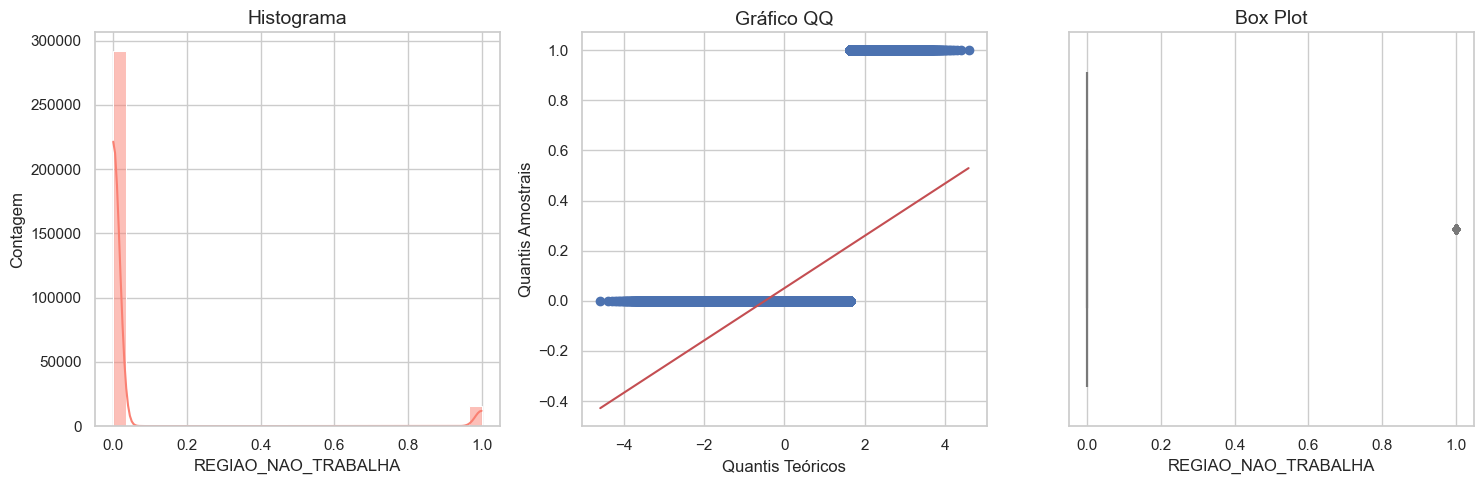

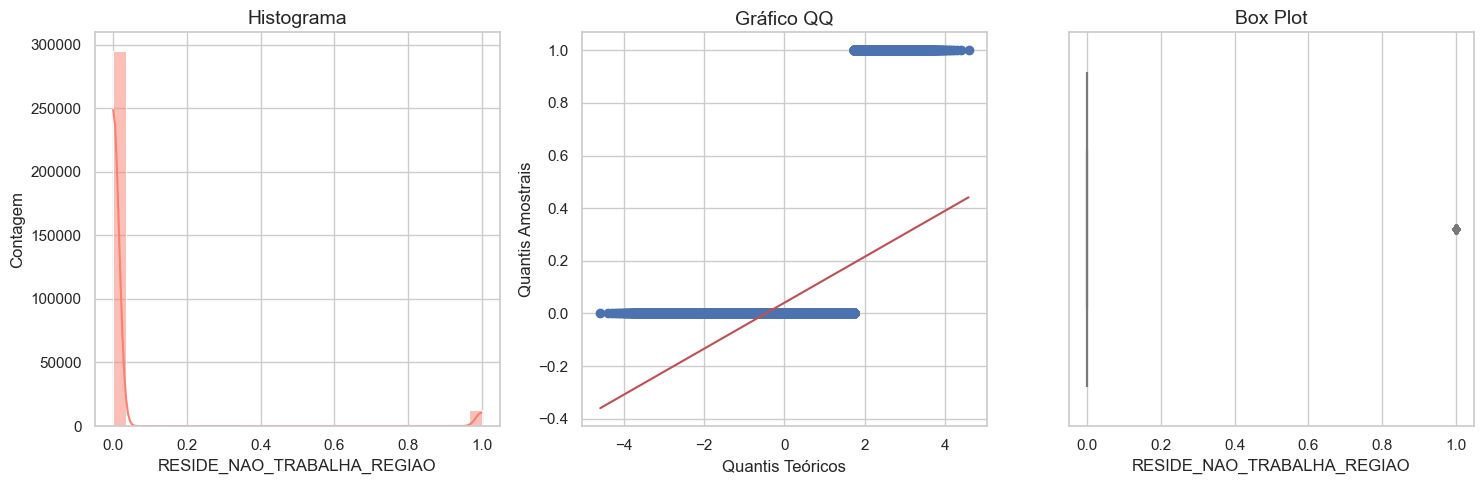

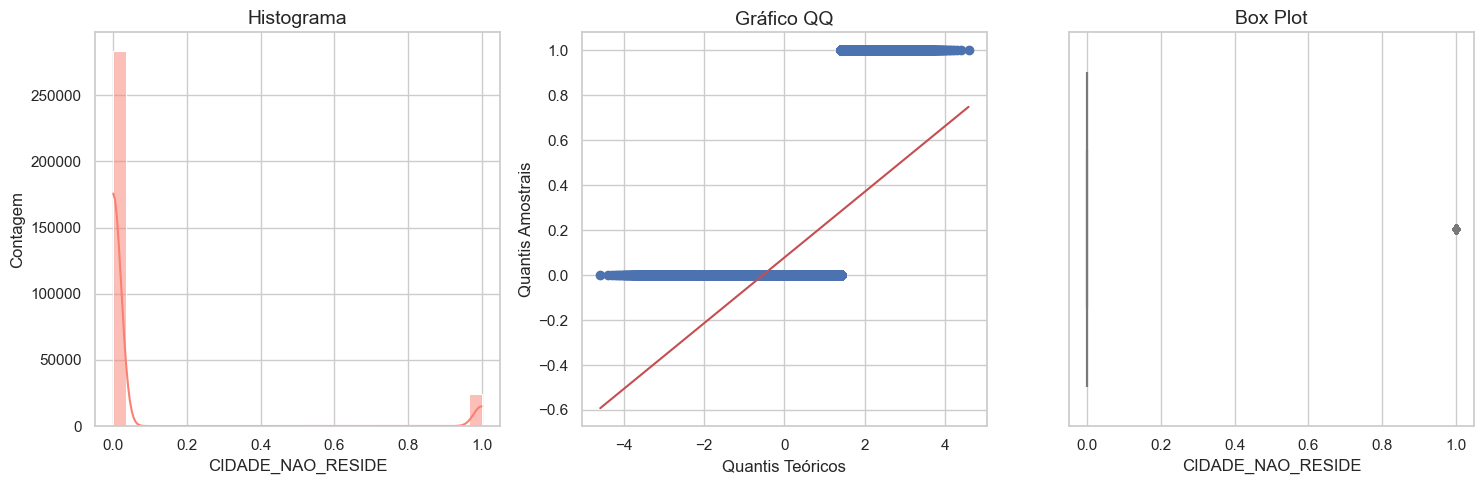

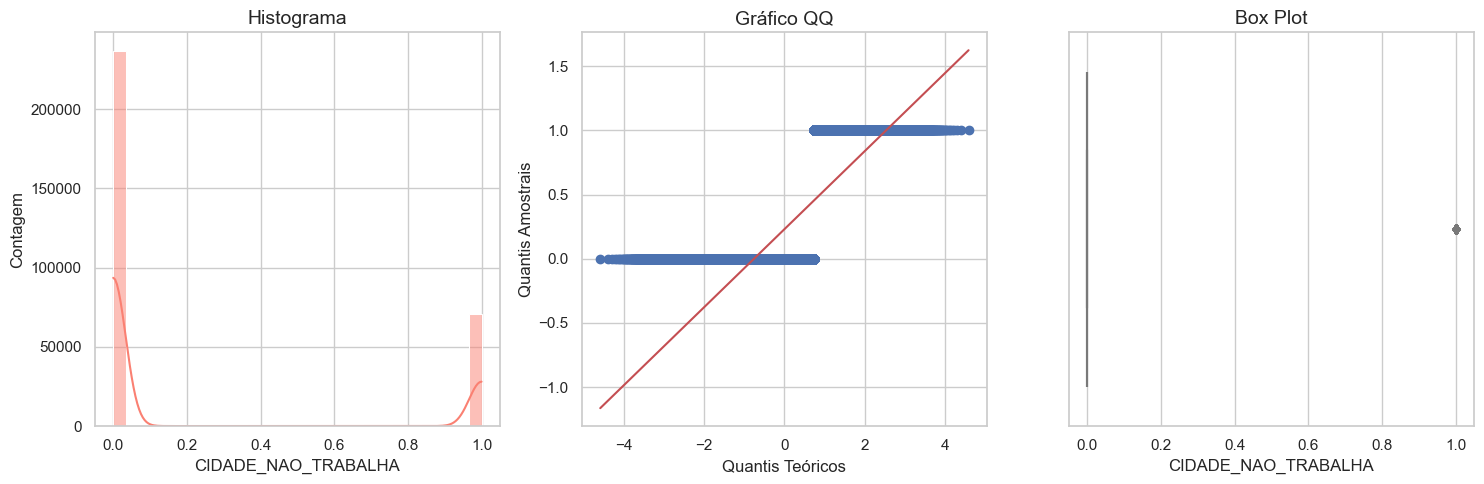

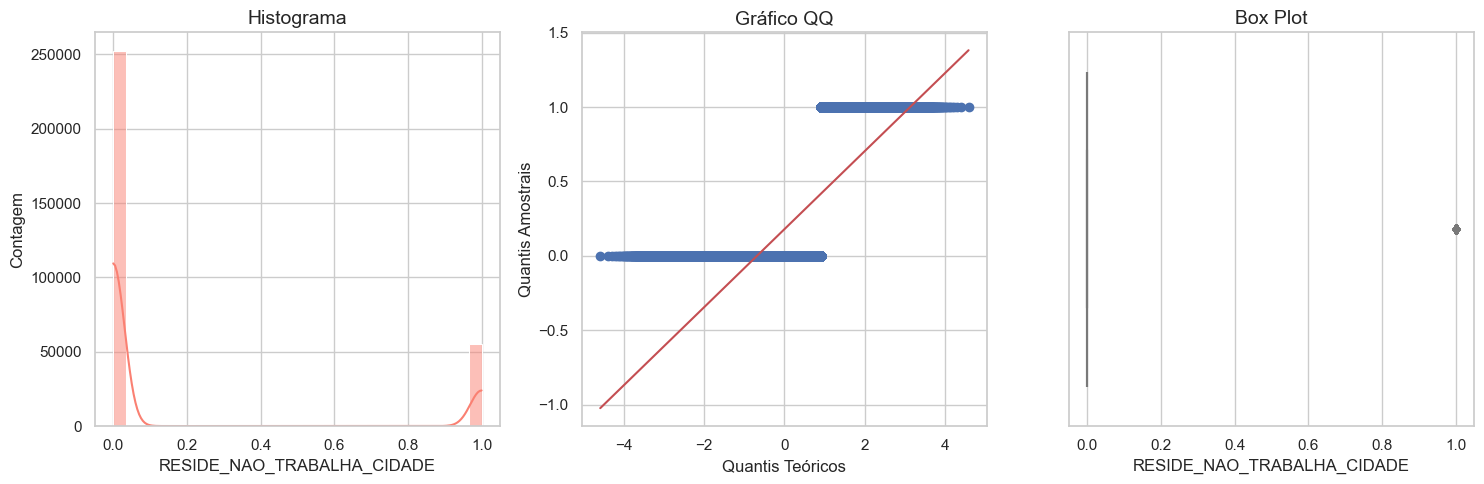

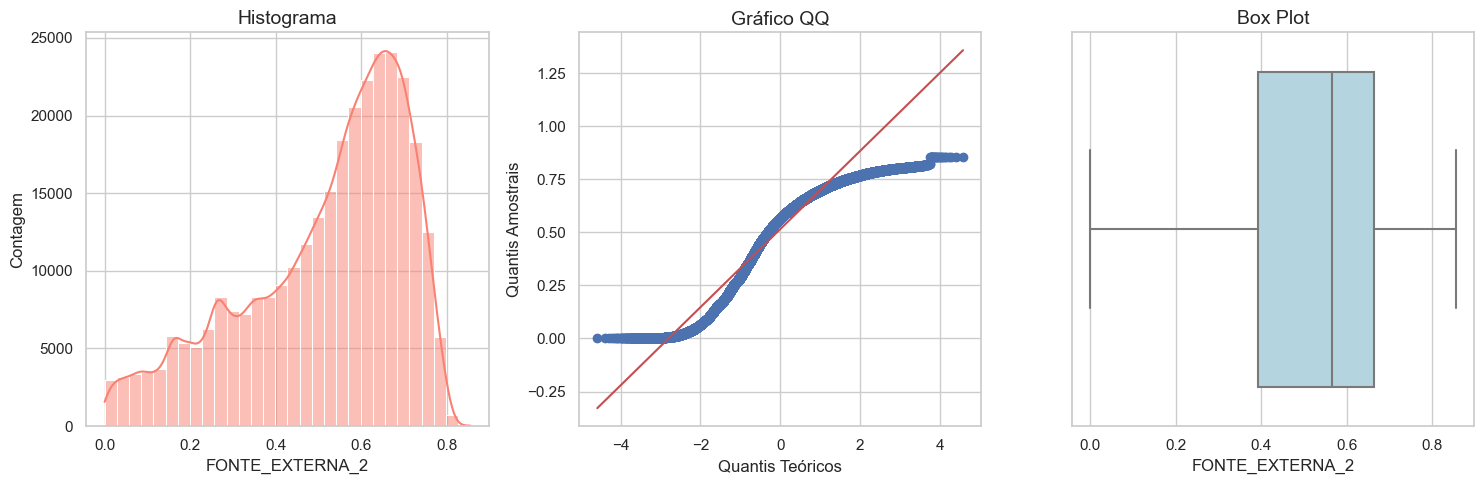

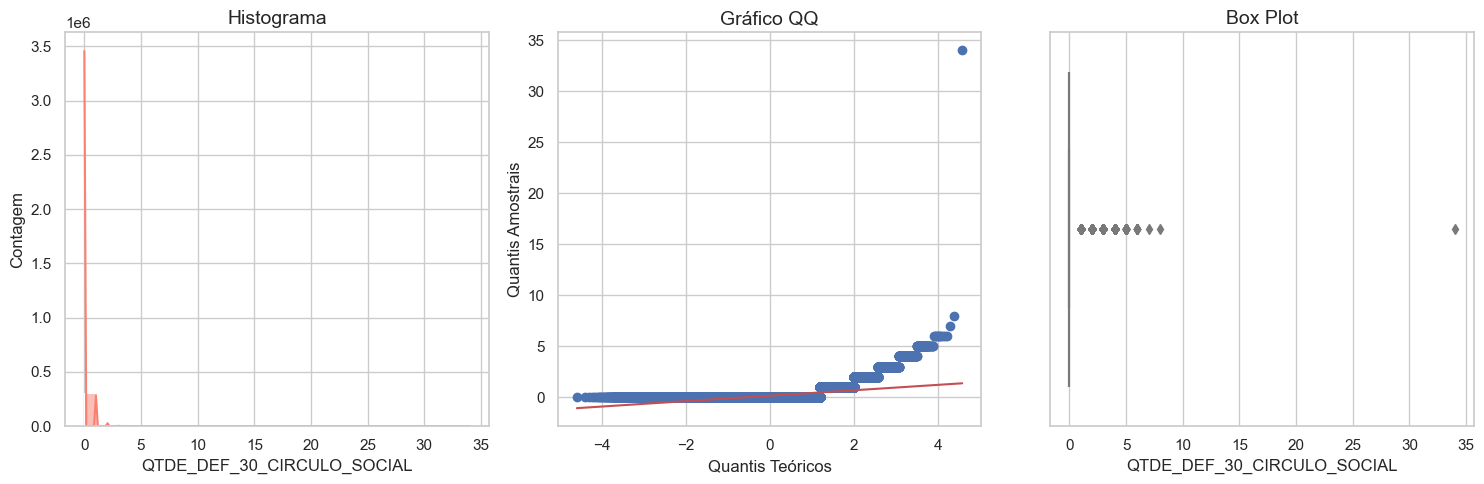

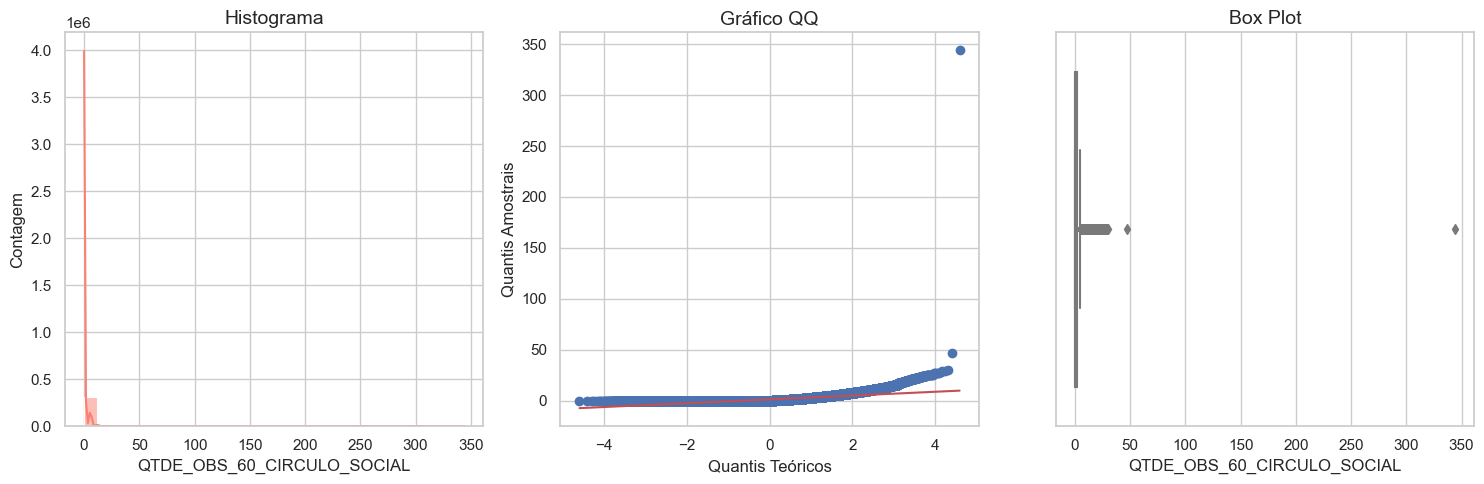

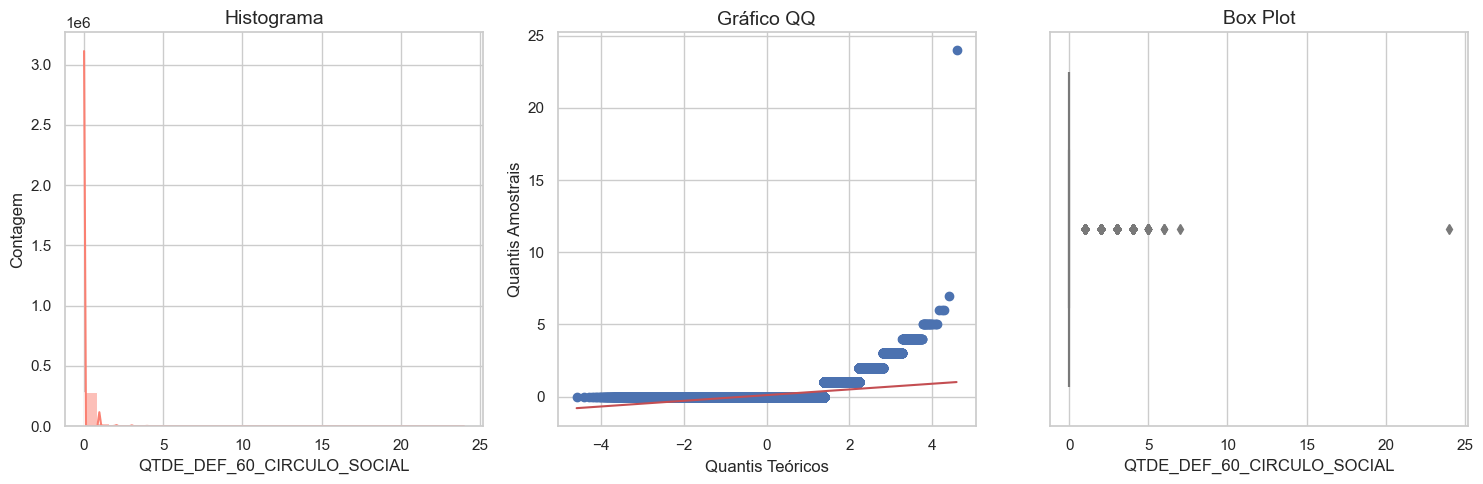

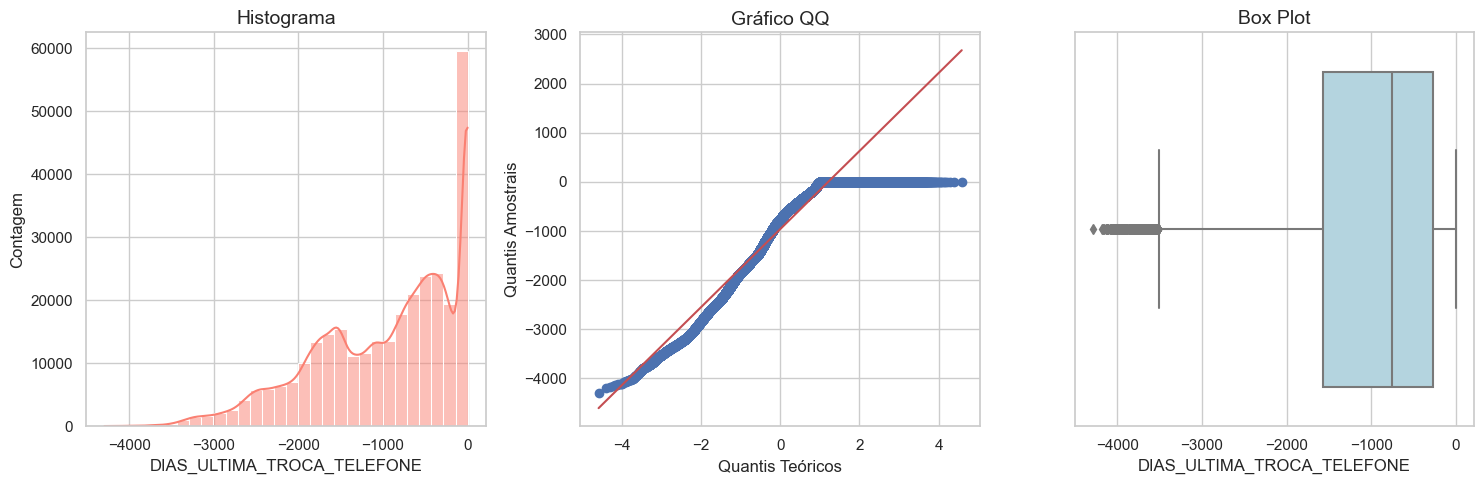

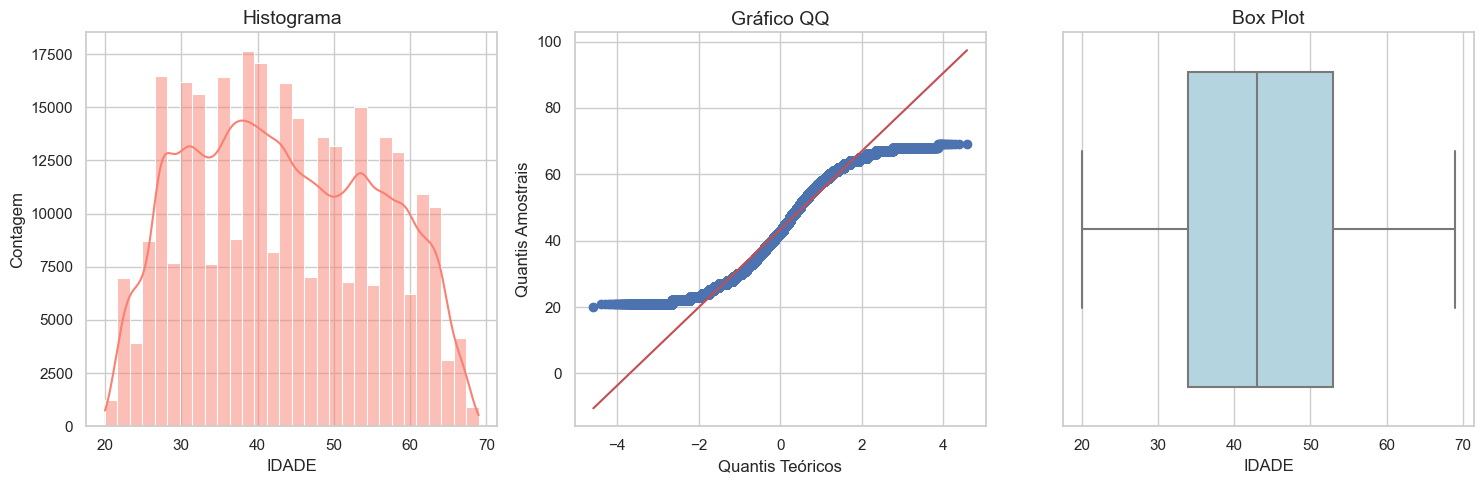

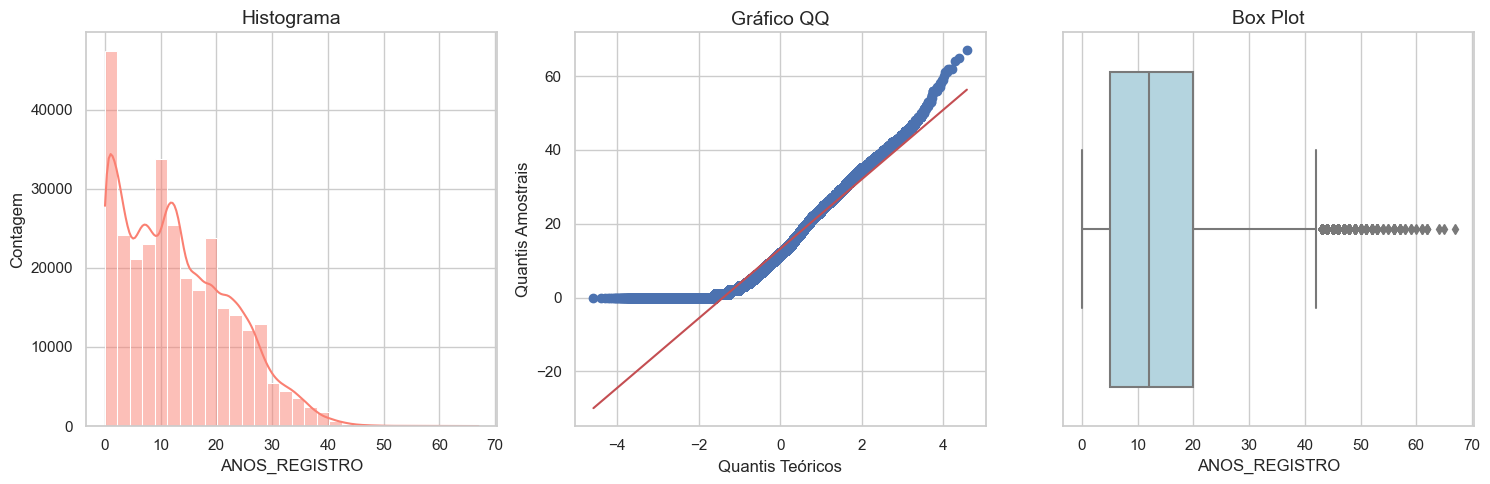

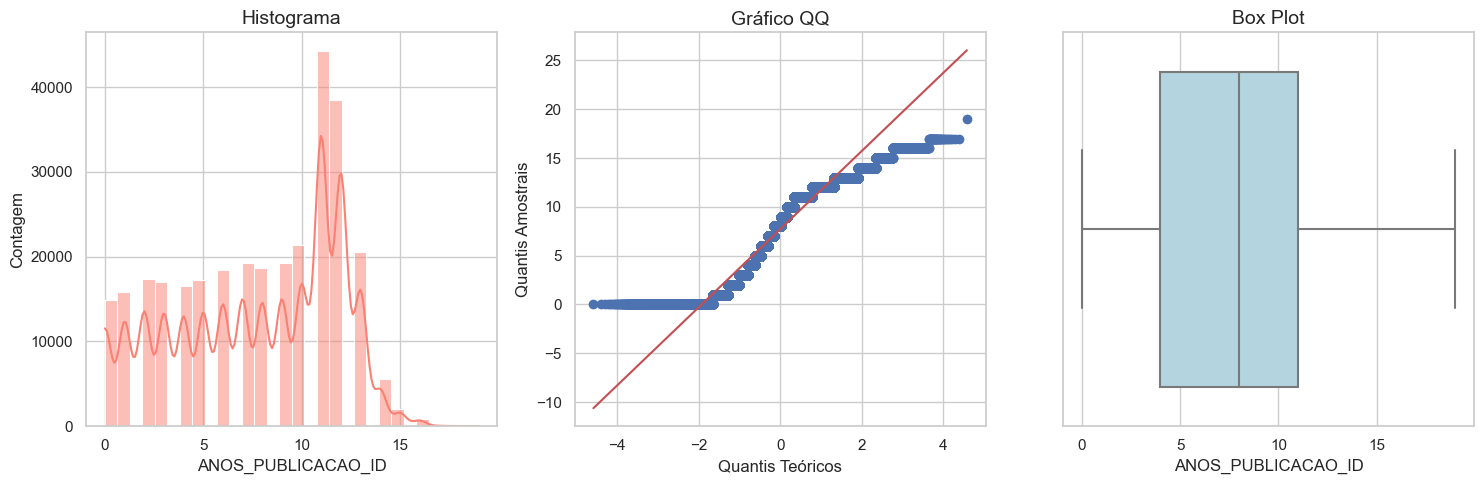

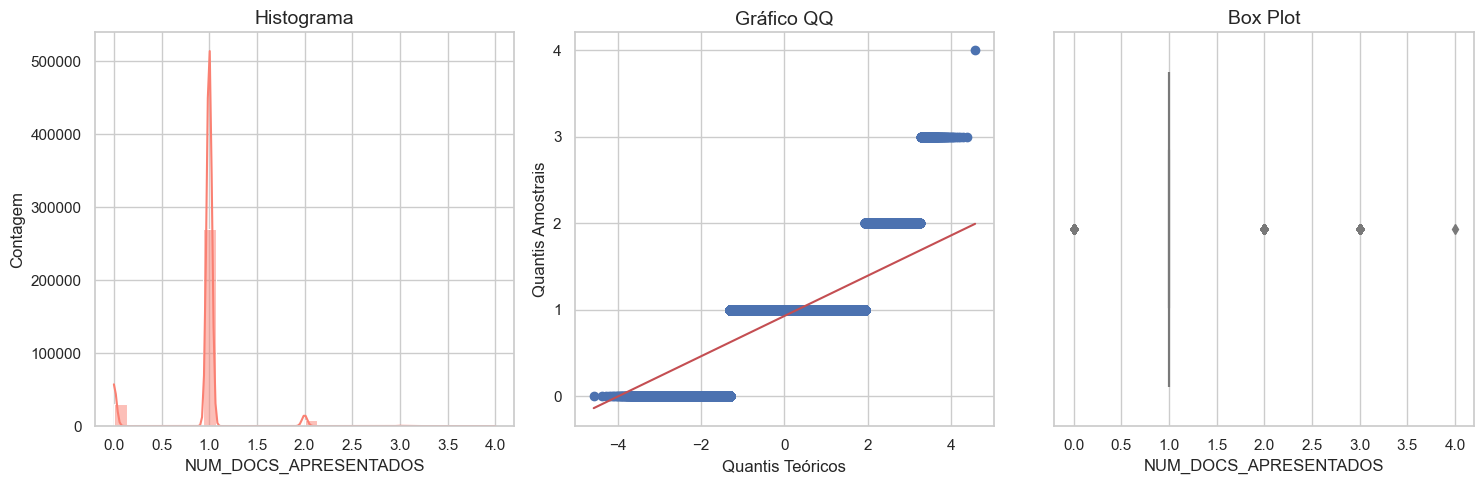

In [94]:
# Construção de histogramas, box plots e gráficos QQhttp://localhost:8888/notebooks/Desktop/amanda/tcc_v3.ipynb#4.3---Distribui%C3%A7%C3%A3o-das-vari%C3%A1veis-num%C3%A9ricas

# Aplicar estilo dos gráficos
sns.set(style='whitegrid')

# Função para plotar análise univariada de variáveis numéricas com estilo e cores personalizados
def plotar_analise_univariada_numerica(df, nome_coluna):
    if df[nome_coluna].dtype in ['int64', 'float64']:
        plt.figure(figsize=(15, 5))

        # Histograma com cor e estilo personalizados
        plt.subplot(1, 3, 1)
        sns.histplot(df[nome_coluna], kde=True, color='salmon', bins=30)
        plt.title('Histograma', fontsize=14)
        plt.xlabel(nome_coluna, fontsize=12)
        plt.ylabel('Contagem', fontsize=12)

        # Gráfico QQ com estilo personalizado
        plt.subplot(1, 3, 2)
        stats.probplot(df[nome_coluna], dist="norm", plot=plt)
        plt.title('Gráfico QQ', fontsize=14)
        plt.xlabel('Quantis Teóricos', fontsize=12)
        plt.ylabel('Quantis Amostrais', fontsize=12)

        # Box Plot com cor e estilo personalizados
        plt.subplot(1, 3, 3)
        sns.boxplot(x=df[nome_coluna], color='lightblue', fliersize=5)
        plt.title('Box Plot', fontsize=14)
        plt.xlabel(nome_coluna, fontsize=12)

        plt.tight_layout()
        plt.show()

# Selecionar colunas numéricas
colunas_numericas = df_renomeado.select_dtypes(include=['int64', 'float64']).columns

# Plotar para cada coluna numérica
for coluna in colunas_numericas:
    plotar_analise_univariada_numerica(df_renomeado, coluna)


## 4.4 - Análises Complementares 

### 4.41 - Análise 1: Profissão/Formação Acadêmica x Renda 

In [88]:
# Agrupar os dados por 'TIPO_EDUCACAO' e 'TIPO_RENDA' e calcular as estatísticas
estatisticas_educacao_renda = df_renomeado.groupby(['NIVEL_EDUCACAO', 'TIPO_RENDA']).agg({
    'RENDA_TOTAL': ['mean', 'median', 'count', 'max']
})

#mean: média
#median: mediana
#count: contagem
#max: máximo

print(estatisticas_educacao_renda)
print('\nConclusões Resumidas:')
print('- Empresários e associados comerciais com ensino superior geralmente têm rendas mais altas.')
print('- Associados comerciais com diferentes níveis educacionais apresentam faixas de renda variadas, refletindo o impacto da indústria.')
print('- Indivíduos com ensino médio, especialmente empregados, têm uma ampla gama de rendas, sugerindo diversas oportunidades de carreira.')
print('- Pensionistas, servidores públicos e empregados com variados níveis educacionais mostram padrões variados de renda.')
print('- Valores discrepantes em faixas de renda amplas podem exigir investigação para entender os fatores que contribuem para esses extremos.')


                                                      RENDA_TOTAL            \
                                                             mean    median   
NIVEL_EDUCACAO                TIPO_RENDA                                      
Academic degree               Commercial associate  274688.372093  247500.0   
                              Pensioner             203919.230769  155700.0   
                              State servant         258847.826087  225000.0   
                              Working               226312.500000  202500.0   
Higher education              Businessman           652500.000000  495000.0   
                              Commercial associate  242283.998486  202500.0   
                              Maternity leave       195000.000000  135000.0   
                              Pensioner             171455.114974  148500.0   
                              State servant         207116.161080  180000.0   
                              Student               

### 4.42 - Análise 2: Gênero x inadimplência e ter carro ou nao

AttributeError: 'numpy.int64' object has no attribute 'startswith'

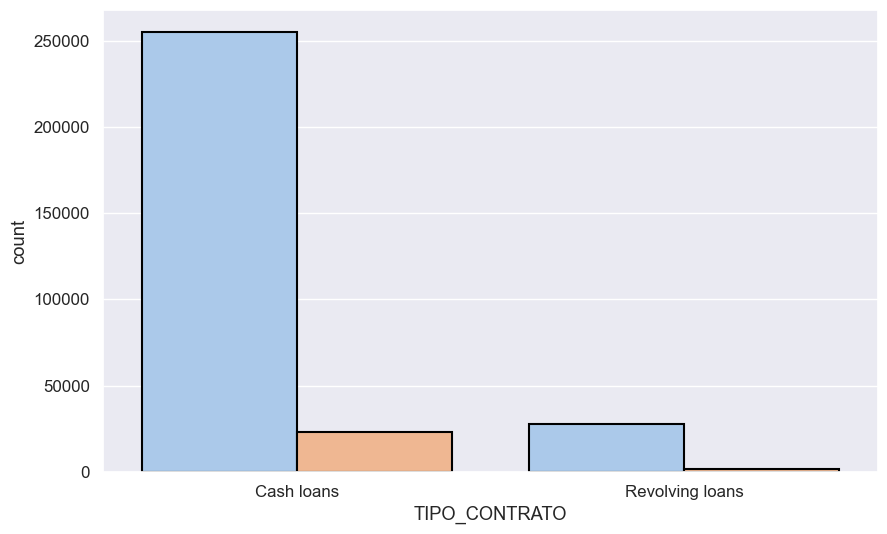

In [86]:
colunas_bivariadas = ['TIPO_CONTRATO', 'GENERO', 'POSSUI_CARRO', 'RENDA_TOTAL', 'VALOR_CREDITO', 'IDADE']

# Definir um estilo diferente para os gráficos
sns.set(style="darkgrid", palette="pastel", font_scale=1.1)

for coluna in colunas_bivariadas:
    if df_renomeado[coluna].dtype == 'O' or df_renomeado[coluna].dtype.name == 'category':
        # Variáveis categóricas
        plt.figure(figsize=(10, 6))
        sns.countplot(x=coluna, hue="TARGET", data=df_renomeado, edgecolor="black", linewidth=1.5)
        plt.title(f'TARGET vs. {coluna}', fontsize=16, weight='bold')
        plt.xlabel(coluna, fontsize=14)
        plt.ylabel('Contagem', fontsize=14)
        plt.xticks(rotation=45)
        plt.show()
    else:
        continue

# Exibir conclusões resumidas em tópicos
print('Conclusões:')
print('''
1. Empréstimos em dinheiro apresentam maiores taxas de inadimplência.
2. Homens possuem menor número de empréstimos, mas maior taxa de inadimplência em comparação com mulheres, sugerindo que o gênero pode influenciar o comportamento no pagamento de empréstimos.
3. A posse de um carro não afeta significativamente a inadimplência, pois as taxas são similares para quem possui ou não carro.
''')


### 4.43 - Análise 3: Tipo de Educacao e Moradia x Inadimplencia

AttributeError: 'numpy.int64' object has no attribute 'startswith'

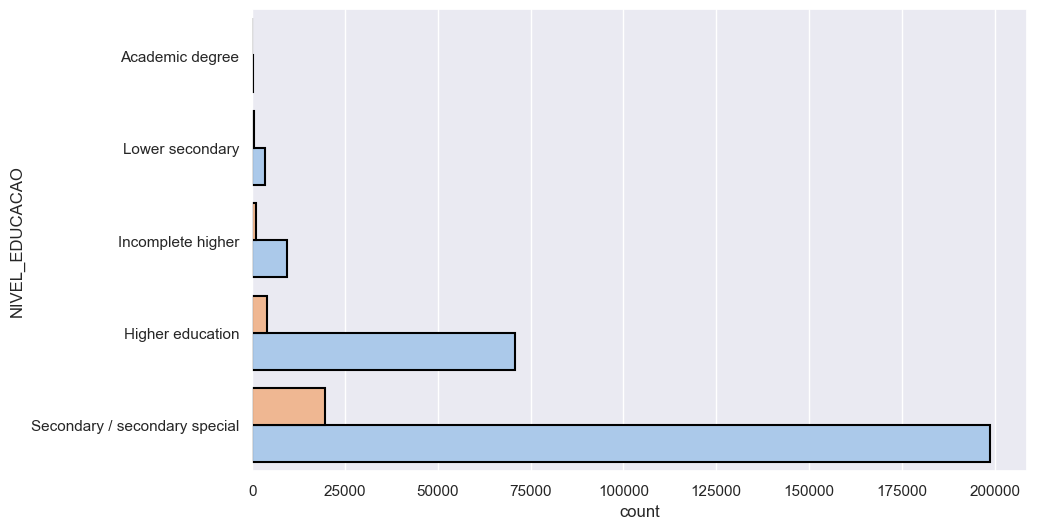

In [91]:
sns.set(style="darkgrid", palette="pastel")

# Gráfico 1 - Nível de Educação vs. TARGET
plt.figure(figsize=(10, 6))
sns.countplot(y='NIVEL_EDUCACAO', hue='TARGET', data=df_renomeado, edgecolor='black', linewidth=1.5)
plt.title('NIVEL_EDUCACAO vs. TARGET', fontsize=14, fontweight='bold')
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('NIVEL_EDUCACAO', fontsize=12)
plt.legend(title='TARGET', loc='upper right')
plt.show()

print('Conclusão sobre Nível de Educação:')
print('''
1. Indivíduos com níveis mais altos de educação (como ensino superior) tendem a ter taxas de inadimplência mais baixas.
2. As taxas de inadimplência são mais altas entre pessoas com níveis educacionais mais baixos.
''')

# Gráfico 2 - Tipo de Moradia vs. TARGET
plt.figure(figsize=(10, 6))
sns.countplot(y='TIPO_MORADIA', hue='TARGET', data=df_renomeado, edgecolor='black', linewidth=1.5)
plt.title('TIPO_MORADIA vs. TARGET', fontsize=14, fontweight='bold')
plt.xlabel('Contagem', fontsize=12)
plt.ylabel('TIPO_MORADIA', fontsize=12)
plt.legend(title='TARGET', loc='upper right')
plt.show()

print('Conclusão sobre Tipo de Moradia:')
print('''
1. Pessoas que moram em apartamentos alugados ou com parentes apresentam taxas de inadimplência mais altas.
2. A posse de imóveis parece estar relacionada a uma menor taxa de inadimplência.
''')

print('Conclusão geral sobre Ocupação:')
print('''
Profissões de baixa qualificação estão associadas a taxas de inadimplência mais elevadas.
Compreender esses padrões pode auxiliar na análise de risco e na formulação de estratégias para perfis de clientes específicos.
''')

### 4.44 - Análise 4: Carro próprio e telefone x Inadimplência

In [ ]:
sns.set(style="whitegrid")

# Create a grouped bar plot for TARGET = 0
plt.figure(figsize=(12, 6))
sns.countplot(x="POSSUI_CARRO", hue="NIVEL_EDUCACAO", data=df_renomeado[df_renomeado['TARGET'] == 0], palette="Set1")
plt.title('TARGET = 0: Carro próprio e Educação')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x="FLAG_TELEFONE", hue="NIVEL_EDUCACAO", data=df_renomeado[df_renomeado['TARGET'] == 0], palette="Set1")
plt.title('TARGET = 0: Telefone próprio e Educação')
plt.show()

# Create a grouped bar plot for TARGET = 1
plt.figure(figsize=(12, 6))
sns.countplot(x="POSSUI_CARRO", hue="NIVEL_EDUCACAO", data=df_renomeado[df_renomeado['TARGET'] == 1], palette="Set1")
plt.title('TARGET = 1: Carro próprio e Educação')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x="FLAG_TELEFONE", hue="NIVEL_EDUCACAO", data=df_renomeado[df_renomeado['TARGET'] == 1], palette="Set1")
plt.title('TARGET = 1: Telefone próprio e Educação')
plt.show()

print('Conclusão: O tipo de educação desempenha um papel significativo tanto em empréstimos sem inadimplência quanto em inadimplentes. A educação "Secundária / secundária especial" se destaca em ambas as categorias. Ter um telefone (Has_Phone = 1) parece ser comum em ambos os tipos de empréstimos, indicando sua prevalência em todos os níveis de educação. A posse de um carro (S/N) não mostra uma distinção clara entre empréstimos sem inadimplência e inadimplentes.')

### 4.45 - Análise 5: Número de documentos apresentados x Inadimplência 

In [ ]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", palette="deep", font_scale=1.1)

sns.countplot(x='NUM_DOCS_APRESENTADOS', hue='TARGET', data=df_renomeado, edgecolor="black", linewidth=1.5)
plt.title('Quantidade de documentos apresentados vs. TARGET', fontsize=14, weight='bold')
plt.xlabel('Número de Documentos', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print('Conclusões:')
print('''
1. Indivíduos que apresentam menos documentos tendem a ter menor inadimplência.
2. Categorias com 100% de inadimplência devem ser analisadas com cautela, pois podem não representar adequadamente a população.
3. O número de documentos pode estar correlacionado ao risco de inadimplência, sendo um fator a ser monitorado.
''')


# 5 - Implementação dos Modelos 

## 5.1 - Árvores de Decisão - Modelos 01: Base completa

### 5.1.1 - Árvore de Decisão 01

In [27]:
# Interpretando a 1a arvore
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Separação das variáveis independentes e dependentes:  
X = df_renomeado.drop(columns=['TARGET'])
y = df_renomeado['TARGET']
    
# 2) Codificação de variáveis categóricas: Converte variáveis categóricas em variáveis dummy/indicadoras.
X = pd.get_dummies(X)

# 3) Divisão dos dados em conjuntos de treino e teste:  
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Conjunto de dados de entrada. Array-like, matriz de características.
    y,  # Conjunto de rótulos. Array-like, vetor de rótulos.
    test_size=0.3,  # Proporção do conjunto de teste. 30% dos dados são reservados para teste.
    train_size=0.7,  # Proporção do conjunto de treino (se não especificado, é complementado pelo test_size)
    random_state=42,  # Semente para reprodutibilidade
    shuffle=True,  # Se os dados devem ser embaralhados antes da divisão
    stratify=y  # Se não for None, os dados são divididos de forma estratificada com base nesta variável.
)

# 4) Inicialização do classificador de Árvore de Decisão com parâmetros explícitos
dt_clf = DecisionTreeClassifier(
    criterion='entropy',  # Critério de divisão (podendo ser 'gini' ou 'entropy')
    splitter='best',  # Estratégia de divisão
    max_depth=10,  # Limitar a profundidade máxima da árvore
    min_samples_split=10,  # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,  # Número mínimo de amostras em um nó folha
    min_weight_fraction_leaf=0.0,  # Fração mínima de peso em um nó folha
    max_features='sqrt',  # Número de características a serem consideradas para a melhor divisão
    random_state=42,  # Semente para reprodutibilidade
    max_leaf_nodes=None,  # Número máximo de nós folha
    min_impurity_decrease=0.0,  # Redução mínima de impureza para dividir um nó
    class_weight='balanced',  # Pesos associados às classes
    ccp_alpha=0.0  # Complexidade de poda
)

dt_clf.fit(X_train, y_train)

Decision Tree Model Evaluation
Cutoff: 0.50
Accuracy: 0.6072
ROC AUC: 0.6320
Sensitivity (Recall): 0.5851
Specificity: 0.6091
Precision: 0.1162
F1-Score: 0.1939


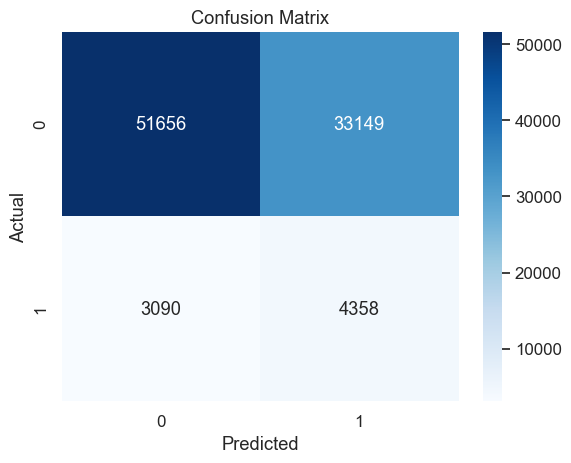

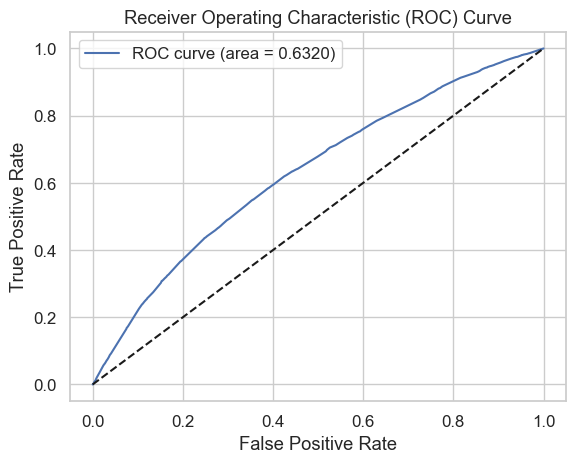

Profundidade máxima da árvore (max_depth): 10
Número mínimo de amostras para dividir um nó (min_samples_split): 10
Número mínimo de amostras em um nó folha (min_samples_leaf): 5
Redução mínima de impureza para dividir um nó (min_impurity_decrease): 0.0
Critério de divisão: entropy
Peso das classes: balanced

Avaliação com cutoff = 0.3:
Cutoff: 0.30
Accuracy: 0.1807
ROC AUC: 0.6320
Sensitivity (Recall): 0.9495
Specificity: 0.1132
Precision: 0.0860
F1-Score: 0.1576


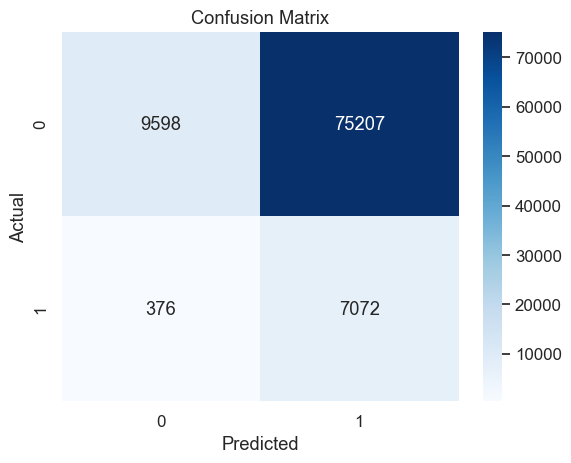

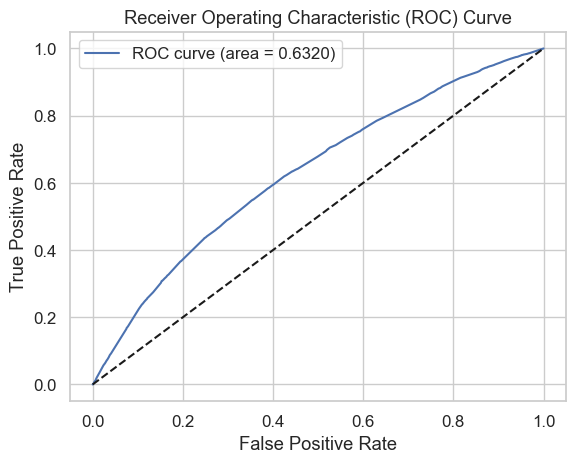


Avaliação com cutoff = 0.5:
Cutoff: 0.50
Accuracy: 0.6072
ROC AUC: 0.6320
Sensitivity (Recall): 0.5851
Specificity: 0.6091
Precision: 0.1162
F1-Score: 0.1939


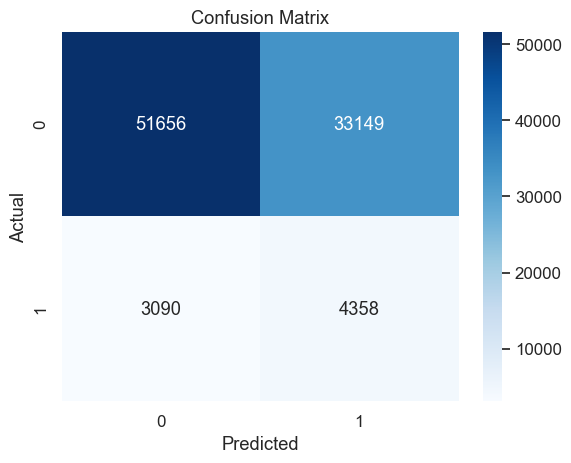

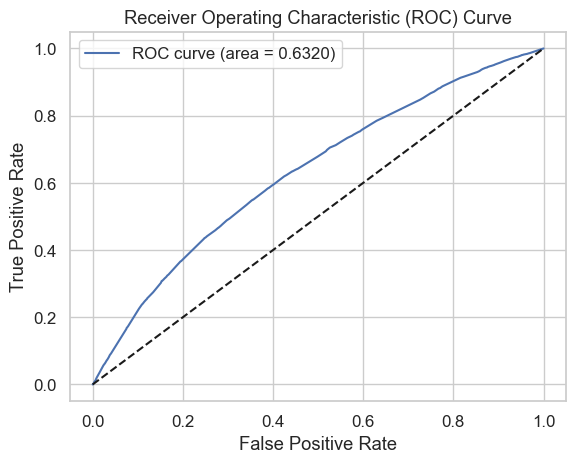


Avaliação com cutoff = 0.7:
Cutoff: 0.70
Accuracy: 0.8956
ROC AUC: 0.6320
Sensitivity (Recall): 0.0732
Specificity: 0.9678
Precision: 0.1664
F1-Score: 0.1017


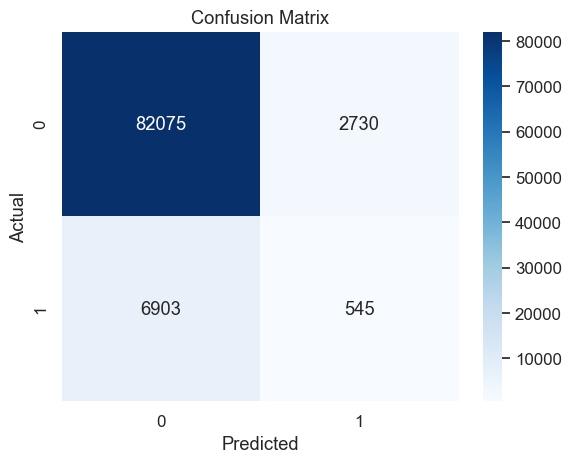

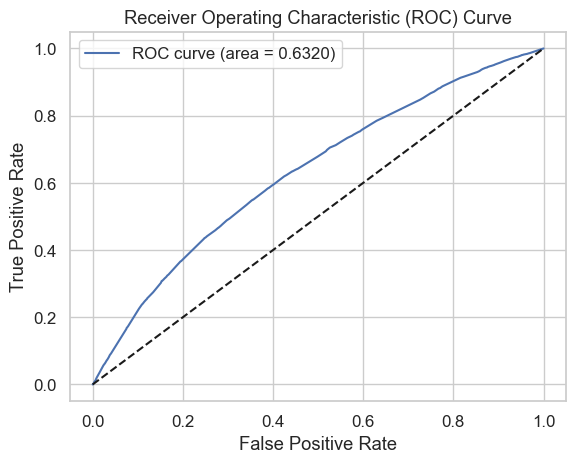

In [30]:
# 5) Função para avaliação do modelo
def evaluate_model(clf, X_test, y_test, cutoff=0.5):
    # Predições e probabilidades
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilidades para classe 1
    y_pred = (y_pred_proba >= cutoff).astype(int)  # Aplicando cutoff nas probabilidades
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Sensibilidade (Recall), Especificidade, Precisão e F1-Score
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Recall
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if precision + sensitivity > 0 else 0

    # Exibição dos resultados
    print(f'Cutoff: {cutoff:.2f}')
    print(f'Accuracy: {acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1-Score: {f1_score:.4f}')
    
    # Matriz de Confusão
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

# 6) Avaliação do modelo de Árvore de Decisão com cutoff padrão (0.5)
print("Decision Tree Model Evaluation")
evaluate_model(dt_clf, X_test, y_test)

# 7) Exibindo os parâmetros utilizados
print(f"Profundidade máxima da árvore (max_depth): {dt_clf.max_depth}")
print(f"Número mínimo de amostras para dividir um nó (min_samples_split): {dt_clf.min_samples_split}")
print(f"Número mínimo de amostras em um nó folha (min_samples_leaf): {dt_clf.min_samples_leaf}")
print(f"Redução mínima de impureza para dividir um nó (min_impurity_decrease): {dt_clf.min_impurity_decrease}")
print(f"Critério de divisão: {dt_clf.criterion}")
print(f"Peso das classes: {dt_clf.class_weight}")

# 8) Avaliação com diferentes cutoffs (Exemplo de ajuste)
for cutoff in [0.3, 0.5, 0.7]:
    print(f'\nAvaliação com cutoff = {cutoff}:')
    evaluate_model(dt_clf, X_test, y_test, cutoff=cutoff)


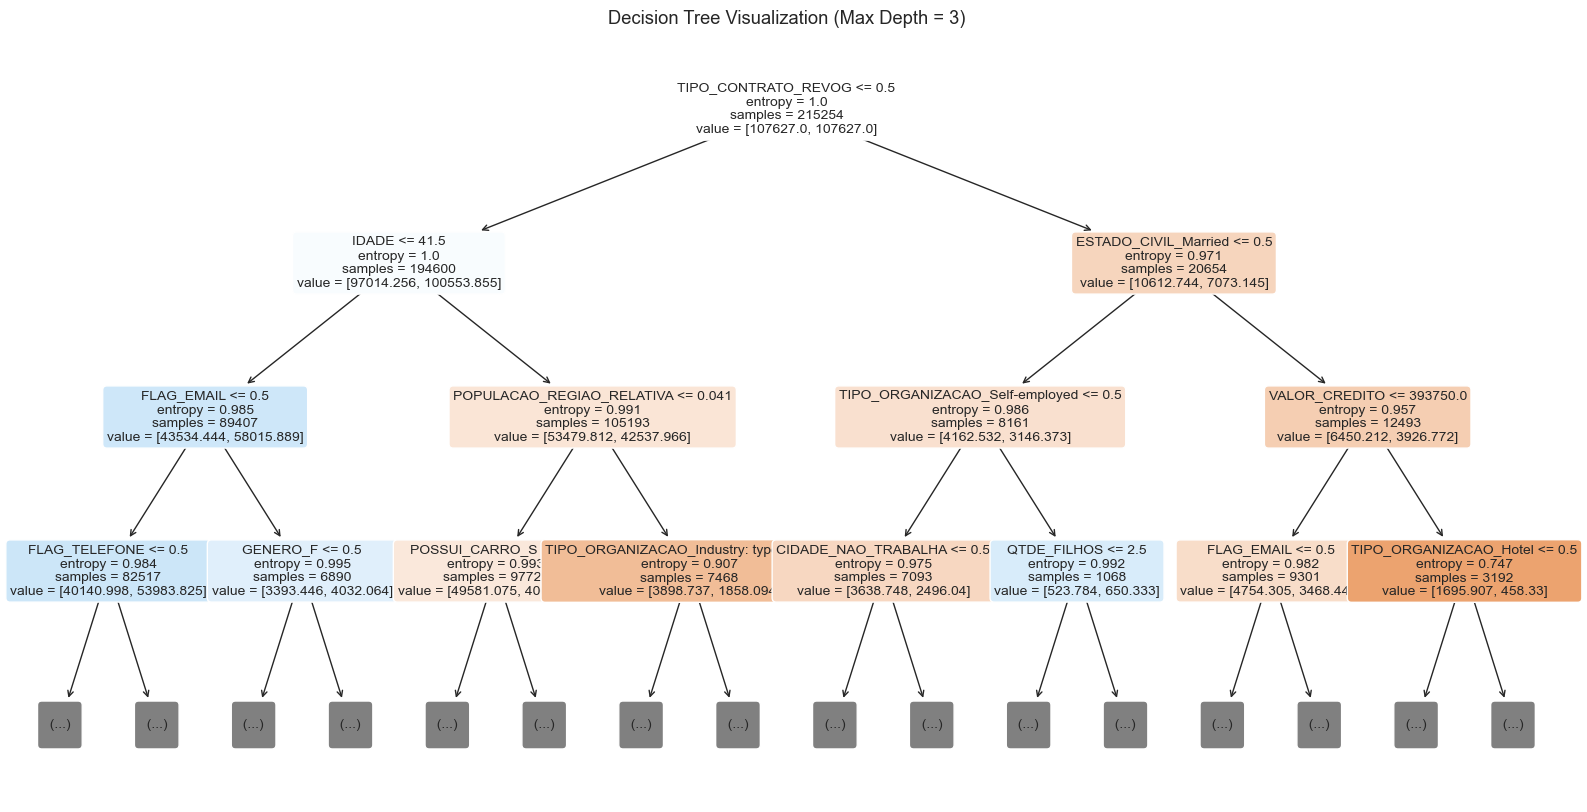

In [31]:
# Passo 8: Visualização da Árvore de Decisão
def plot_decision_tree(clf, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=feature_names, filled=True, rounded=True, max_depth=3, fontsize=10)
    plt.title('Decision Tree Visualization (Max Depth = 3)')
    plt.show()

plot_decision_tree(dt_clf, feature_names=X_test.columns)

### 5.1.2 - Árvore de Decisão com GridSearchCV

<Figure size 600x400 with 0 Axes>

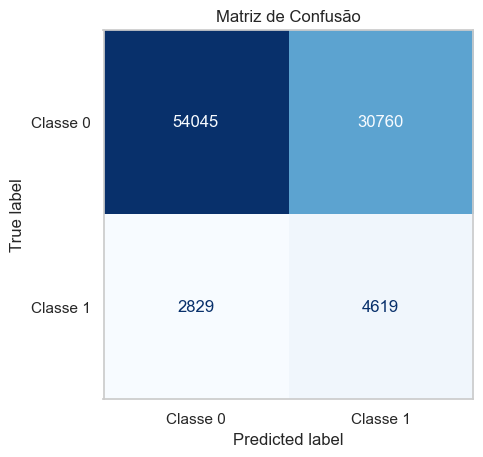

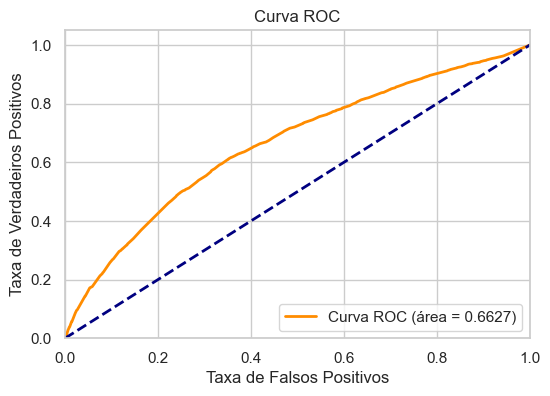

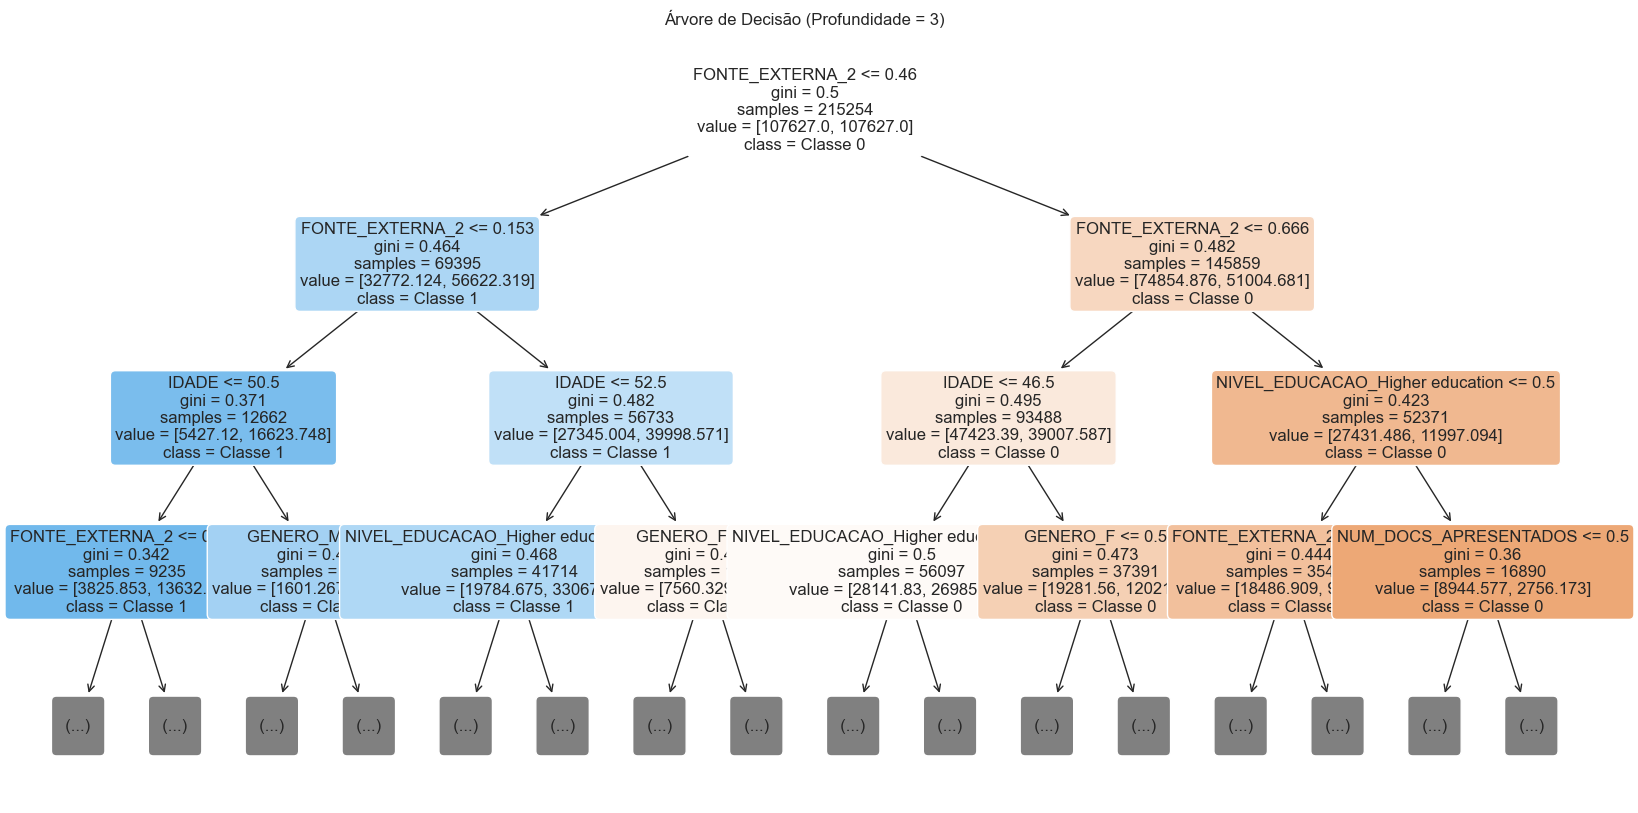

In [95]:
# RASCUNHO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.tree import plot_tree

# Preparação dos dados
X = df_renomeado.drop(columns=['TARGET'])
y = df_renomeado['TARGET']
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42, shuffle=True, stratify=y
)

# Melhores parâmetros do GridSearch
best_params = {'criterion': 'gini', 
               'max_depth': 10, 
               'min_samples_leaf': 10, 
               'min_samples_split': 2, 
               'class_weight': 'balanced'}

# Criação da árvore de decisão com os melhores parâmetros
dt_clf_final = DecisionTreeClassifier(**best_params, random_state=42)
dt_clf_final.fit(X_train, y_train)

# Previsões e avaliação do modelo
y_pred = dt_clf_final.predict(X_test)
y_pred_proba = dt_clf_final.predict_proba(X_test)[:, 1]

# Matriz de Confusão Gráfica
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_estimator(dt_clf_final, X_test, y_test, display_labels=['Classe 0', 'Classe 1'], cmap='Blues', values_format='d',colorbar=False)
plt.title('Matriz de Confusão')
plt.grid(False)  # Remove a grade
plt.show()


# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()



# Gráfico da Árvore de Decisão
plt.figure(figsize=(20, 10))
plot_tree(dt_clf_final, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Classe 0', 'Classe 1'], 
          rounded=True, 
          fontsize=12, 
          max_depth=3)  # Limita a profundidade da árvore

plt.title('Árvore de Decisão (Profundidade = 3)')
plt.show()


Avaliação do Modelo de Árvore de Decisão:
Matriz de Confusão:
[[54045 30760]
 [ 2829  4619]]
Accuracy: 0.6359
AUC ROC: 0.6627
              precision    recall  f1-score   support

    Classe 0       0.95      0.64      0.76     84805
    Classe 1       0.13      0.62      0.22      7448

    accuracy                           0.64     92253
   macro avg       0.54      0.63      0.49     92253
weighted avg       0.88      0.64      0.72     92253

Sensitivity (Recall): 0.6202
Specificity: 0.6373
Precision: 0.1306
F1-Score: 0.2157
Matriz de Confusão (com cutoff = 0.5):
[[54045 30760]
 [ 2829  4619]]


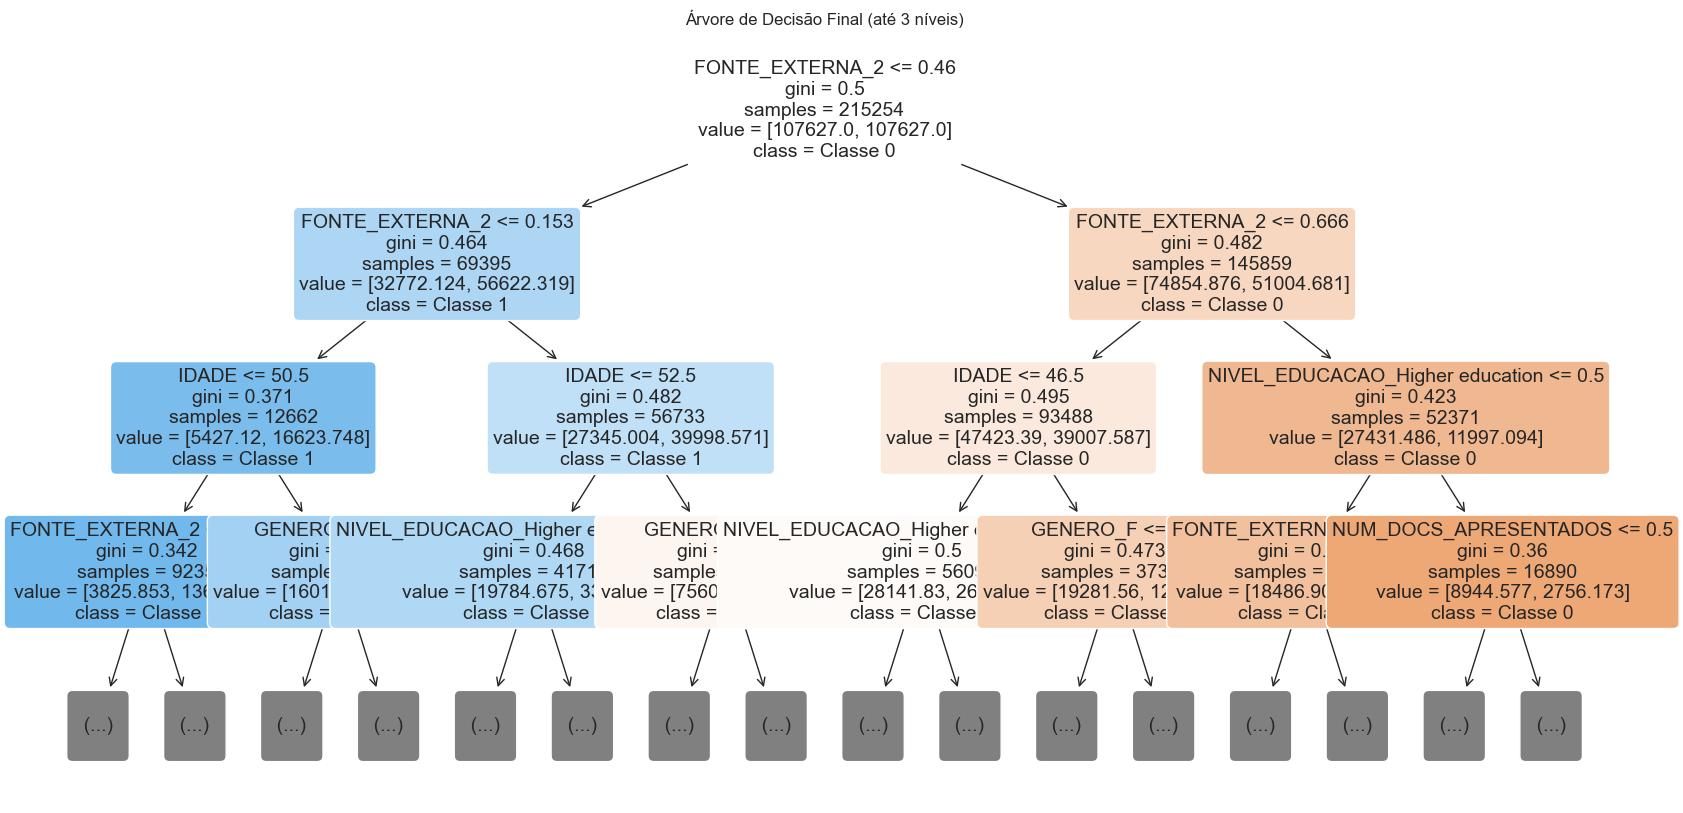

In [95]:
# CÓDIGO DA ÁRVORE COM OS PARÂMETROS SELECIONADOS VIA CODIGO:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Preparação dos dados
X = df_renomeado.drop(columns=['TARGET'])
y = df_renomeado['TARGET']
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42, shuffle=True, stratify=y
)

# Melhores parâmetros do GridSearch
best_params = {'criterion': 'gini', 
               'max_depth': 10, 
               'min_samples_leaf': 10, 
               'min_samples_split': 2, 
               'class_weight': 'balanced'}

# Criação da árvore de decisão com os melhores parâmetros
dt_clf_final = DecisionTreeClassifier(**best_params, random_state=42)
dt_clf_final.fit(X_train, y_train)

# Previsões e avaliação do modelo
y_pred = dt_clf_final.predict(X_test)
y_pred_proba = dt_clf_final.predict_proba(X_test)[:, 1]  # Probabilidades para o cálculo do cutoff

# Avaliação do modelo
print("Avaliação do Modelo de Árvore de Decisão:")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusão:\n{conf_matrix}")

# Métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # AUC ROC
report = classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1'])
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC ROC: {roc_auc:.4f}")
print(report)

# Sensitivity (Recall) e Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Definir e testar diferentes cutoffs
cutoff = 0.5  # Aqui você pode alterar o valor para ajustar o cutoff
y_pred_cutoff = (y_pred_proba >= cutoff).astype(int)
conf_matrix_cutoff = confusion_matrix(y_test, y_pred_cutoff)
print(f"Matriz de Confusão (com cutoff = {cutoff}):\n{conf_matrix_cutoff}")

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Configuração da figura
plt.figure(figsize=(20, 10))

# Plotando a árvore de decisão, limitando a profundidade a 3 níveis
plot_tree(dt_clf_final, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Classe 0', 'Classe 1'], 
          rounded=True, 
          fontsize=14,
          max_depth=3)  # Limita a profundidade da árvore

# Título do gráfico
plt.title('Árvore de Decisão Final (até 3 níveis)')
plt.show()


## 5.2 - Árvores de Decisao - Modelos 02: Base sem dummies
### 5.2.1 - Árvore de Decisão 01

Decision Tree Model Evaluation
Accuracy: 0.6907
ROC AUC: 0.6473


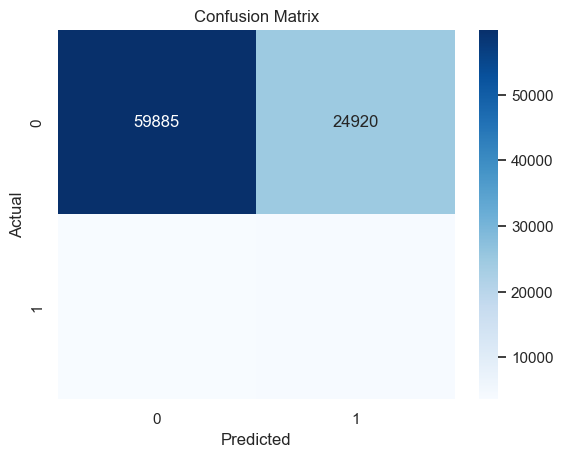

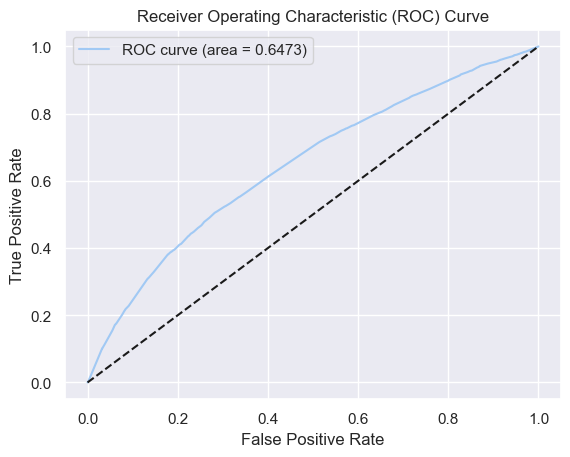

Profundidade máxima da árvore (max_depth): 10
Número mínimo de amostras para dividir um nó (min_samples_split): 10
Número mínimo de amostras em um nó folha (min_samples_leaf): 5
Redução mínima de impureza para dividir um nó (min_impurity_decrease): 0.0


In [97]:
colunas_selecionadas = [
    'GENERO_F','GENERO_M','POSSUI_CARRO_N','POSSUI_CARRO_S','POSSUI_IMOVEL_N','POSSUI_IMOVEL_S',
    'TIPO_CONTRATO_DINH','TIPO_CONTRATO_REVOG'
] 

df_dados_sem_dummies = df_renomeado.drop(columns=colunas_selecionadas)

# 2. Divisão do Conjunto de Dados
# Dividimos os dados em conjuntos de treino e teste para treinar e avaliar os modelos.

# Separar as features (X) e o target (y)
X = df_dados_sem_dummies.drop(columns=['TARGET'])
y = df_dados_sem_dummies['TARGET']

# Transformar variáveis categóricas em variáveis dummy
X = pd.get_dummies(X)

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Conjunto de dados de entrada. Array-like, matriz de características.
    y,  # Conjunto de rótulos. Array-like, vetor de rótulos.
    test_size=0.3,  # Proporção do conjunto de teste. 30% dos dados são reservados para teste.
    train_size=0.7,  # Proporção do conjunto de treino (se não especificado, é complementado pelo test_size)
    random_state=42,  # Semente para reprodutibilidade
    shuffle=True,  # Se os dados devem ser embaralhados antes da divisão
    stratify=y  # Se não for None, os dados são divididos de forma estratificada com base nesta variável.
)

# 3. Treinamento de um Modelo de Árvore de Decisão
# Treinamos uma Árvore de Decisão usando DecisionTreeClassifier do Scikit-learn.
dt_clf = DecisionTreeClassifier(
    criterion='entropy',  # Critério de divisão (podendo ser 'gini' ou 'entropy')
    splitter='best',  # Estratégia de divisão
    max_depth=10,  # Limitar a profundidade máxima da árvore
    min_samples_split=10,  # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,  # Número mínimo de amostras em um nó folha
    min_weight_fraction_leaf=0.0,  # Fração mínima de peso em um nó folha
    max_features='sqrt',  # Número de características a serem consideradas para a melhor divisão
    random_state=42,  # Semente para reprodutibilidade
    max_leaf_nodes=None,  # Número máximo de nós folha
    min_impurity_decrease=0.0,  # Redução mínima de impureza para dividir um nó
    class_weight='balanced',  # Pesos associados às classes
    ccp_alpha=0.0  # Complexidade de poda
)

dt_clf.fit(X_train, y_train)

# 5. Avaliação dos Modelos
# Avaliamos os modelos usando métricas como Acurácia, Matriz de Confusão, ROC-AUC, etc.
def evaluate_model(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    print(f'Accuracy: {acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

print("Decision Tree Model Evaluation")
evaluate_model(dt_clf, X_test, y_test)

print(f"Profundidade máxima da árvore (max_depth): {dt_clf.max_depth}")
print(f"Número mínimo de amostras para dividir um nó (min_samples_split): {dt_clf.min_samples_split}")
print(f"Número mínimo de amostras em um nó folha (min_samples_leaf): {dt_clf.min_samples_leaf}")
print(f"Redução mínima de impureza para dividir um nó (min_impurity_decrease): {dt_clf.min_impurity_decrease}")


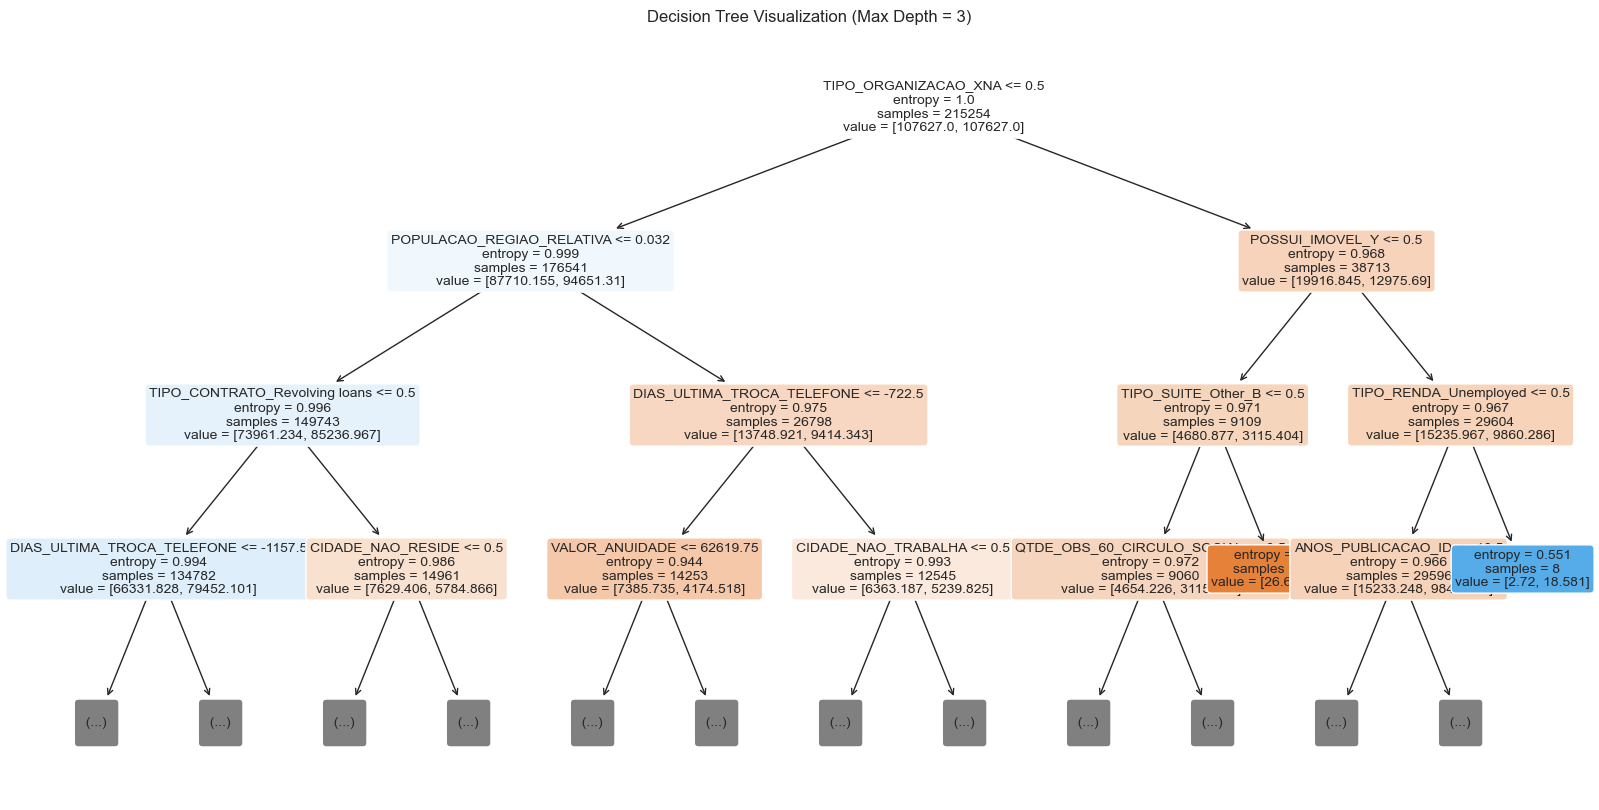

In [99]:
# Função para plotar a árvore de decisão
def plot_decision_tree(clf, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=feature_names, filled=True, rounded=True, max_depth=3, fontsize=10)
    plt.title('Decision Tree Visualization (Max Depth = 3)')
    plt.show()

# Visualização da Árvore de Decisão com alguns nós
plot_decision_tree(dt_clf, feature_names=X_test.columns)

### 5.2.2 - Árvore de Decisão 02 com GridSearchCV

Avaliação do Modelo de Árvore de Decisão:
Matriz de Confusão:
[[54043 30762]
 [ 2828  4620]]
Accuracy: 0.6359
AUC ROC: 0.6628
              precision    recall  f1-score   support

    Classe 0       0.95      0.64      0.76     84805
    Classe 1       0.13      0.62      0.22      7448

    accuracy                           0.64     92253
   macro avg       0.54      0.63      0.49     92253
weighted avg       0.88      0.64      0.72     92253

Sensitivity (Recall): 0.6203
Specificity: 0.6373
Precision: 0.1306
F1-Score: 0.2157

Cutoff: 0.3
Matriz de Confusão (com cutoff = 0.3):
[[25588 59217]
 [ 1131  6317]]
Accuracy: 0.3458
Sensitivity (Recall): 0.8481
Specificity: 0.3017
Precision: 0.0964
F1-Score: 0.1731

Cutoff: 0.5
Matriz de Confusão (com cutoff = 0.5):
[[54043 30762]
 [ 2828  4620]]
Accuracy: 0.6359
Sensitivity (Recall): 0.6203
Specificity: 0.6373
Precision: 0.1306
F1-Score: 0.2157

Cutoff: 0.7
Matriz de Confusão (com cutoff = 0.7):
[[76154  8651]
 [ 5451  1997]]
Accuracy: 0.

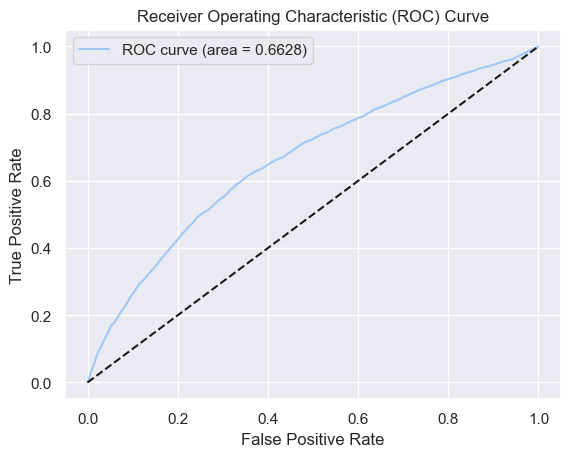

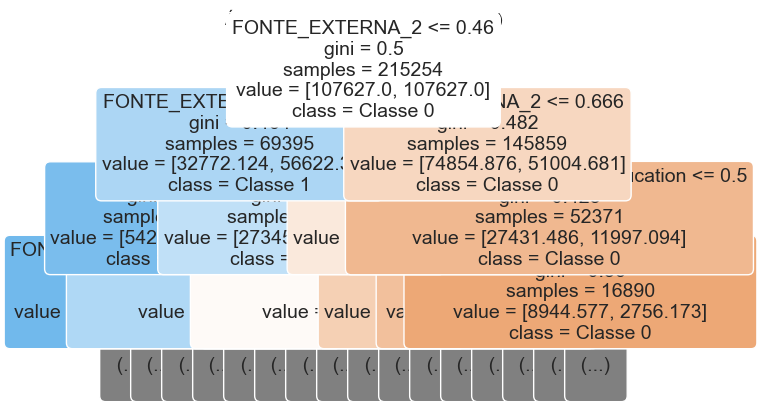

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, roc_curve, 
                             recall_score, precision_score, f1_score, classification_report)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

colunas_selecionadas = [
    'GENERO_F','GENERO_M','POSSUI_CARRO_N','POSSUI_CARRO_S','POSSUI_IMOVEL_N','POSSUI_IMOVEL_S',
    'TIPO_CONTRATO_DINH','TIPO_CONTRATO_REVOG'
] 

df_dados_sem_dummies = df_renomeado.drop(columns=colunas_selecionadas)

# Divisão do Conjunto de Dados
X = df_dados_sem_dummies.drop(columns=['TARGET'])
y = df_dados_sem_dummies['TARGET']

# Codificação de variáveis categóricas
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42, shuffle=True, stratify=y
)

# Melhores parâmetros do GridSearch
best_params = {'criterion': 'gini', 
               'max_depth': 10, 
               'min_samples_leaf': 10, 
               'min_samples_split': 2, 
               'class_weight': 'balanced'}

# Criação da árvore de decisão com os melhores parâmetros
dt_clf_final = DecisionTreeClassifier(**best_params, random_state=42)
dt_clf_final.fit(X_train, y_train)

# Previsões e avaliação do modelo
y_pred = dt_clf_final.predict(X_test)
y_pred_proba = dt_clf_final.predict_proba(X_test)[:, 1]  # Probabilidades para o cálculo do cutoff

# Avaliação do modelo
print("Avaliação do Modelo de Árvore de Decisão:")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusão:\n{conf_matrix}")

# Métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=['Classe 0', 'Classe 1'])
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC ROC: {roc_auc:.4f}")
print(report)

# Sensitivity (Recall) e Specificity
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")

# Definir e testar diferentes cutoffs
def evaluate_with_cutoff(y_true, y_pred_proba, cutoff):
    y_pred_cutoff = (y_pred_proba >= cutoff).astype(int)
    conf_matrix_cutoff = confusion_matrix(y_true, y_pred_cutoff)
    
    tn, fp, fn, tp = conf_matrix_cutoff.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = f1_score(y_true, y_pred_cutoff)
    
    print(f"\nCutoff: {cutoff}")
    print(f"Matriz de Confusão (com cutoff = {cutoff}):\n{conf_matrix_cutoff}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

for cutoff in [0.3, 0.5, 0.7]:
    evaluate_with_cutoff(y_test, y_pred_proba, cutoff)

# Visualização da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

# Plotando a árvore de decisão, limitando a profundidade a 3 níveis
plot_tree(dt_clf_final, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Classe 0', 'Classe 1'], 
          rounded=True, 
          fontsize=14,
          max_depth=3)  # Limita a profundidade da árvore

# Título do gráfico
plt.title('Árvore de Decisão Final (até 3 níveis)')
plt.show()

## 5.3 - Random Forest - Modelos 01: Base completa
### 5.3.1 - Random 01

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Interpretando a 2a arvore

# 1) Separação das variáveis independentes e dependentes:  
X = df_renomeado.drop(columns=['TARGET'])
y = df_renomeado['TARGET']
    
# 2) Codificação de variáveis categóricas: Converte variáveis categóricas em variáveis dummy/indicadoras.
X = pd.get_dummies(X)

# 3) Divisão dos dados em conjuntos de treino e teste:  
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    train_size=0.7, 
    random_state=42, 
    shuffle=True, 
    stratify=y
)

# Treinamento do modelo Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,  # Número de árvores na floresta
    criterion='entropy',  # Critério de divisão, podendo ser 'gini' ou 'entropy'
    max_depth=20,  # Limitar a profundidade máxima da árvore
    min_samples_split=10,  # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,  # Número mínimo de amostras em um nó folha
    max_features='sqrt',  # Número de características a serem consideradas para a melhor divisão. Pode ser um número inteiro, uma fração, 'sqrt' ou 'log2'.
    class_weight='balanced',  # Pesos associados às classes. Pode ser 'balanced', 'balanced_subsample' ou um dicionário. Usar 'balanced' pode ajudar a lidar com classes desbalanceadas.
    bootstrap=True,  # Amostras extraídas com reposição. Pode ser True ou False.
    random_state=42  # Semente para reprodutibilidade
)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, random_state=42)


Evaluating with cutoff = 0.3
Cutoff: 0.3
Accuracy: 0.5200
Sensitivity (Recall): 0.7649
Specificity: 0.4985
Precision: 0.1181
F1-Score: 0.2046
ROC AUC: 0.6944


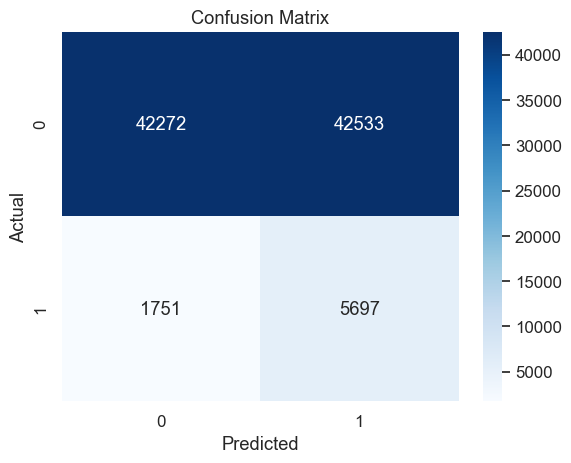


Evaluating with cutoff = 0.5
Cutoff: 0.5
Accuracy: 0.8546
Sensitivity (Recall): 0.2799
Specificity: 0.9051
Precision: 0.2057
F1-Score: 0.2372
ROC AUC: 0.6944


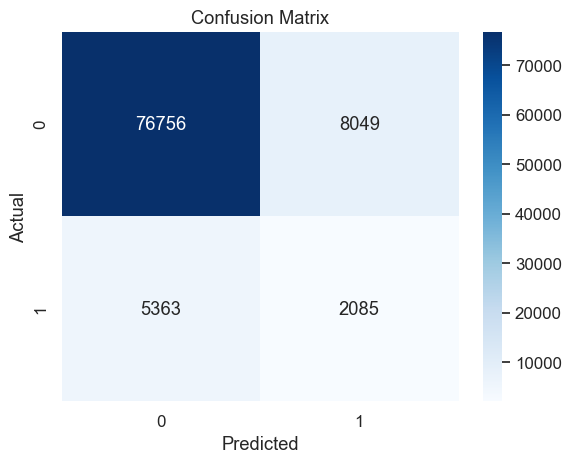


Evaluating with cutoff = 0.7
Cutoff: 0.7
Accuracy: 0.9180
Sensitivity (Recall): 0.0209
Specificity: 0.9967
Precision: 0.3611
F1-Score: 0.0396
ROC AUC: 0.6944


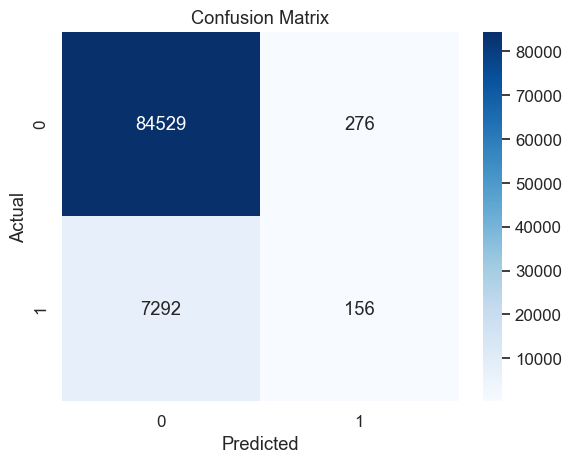

In [42]:
# Função para calcular sensibilidade, especificidade, precisão e F1-Score
def calculate_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = recall_score(y_test, y_pred)  # Recall
    specificity = tn / (tn + fp)  # Verdadeiros negativos / Total de negativos
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, sensitivity, specificity, precision, f1, cm

# Função para avaliar o modelo com diferentes cutoffs
def evaluate_model_with_cutoff(clf, X_test, y_test, cutoff=0.5):
    y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1
    y_pred_cutoff = (y_proba >= cutoff).astype(int)  # Ajuste do cutoff

    # Calculando métricas
    accuracy, sensitivity, specificity, precision, f1, cm = calculate_metrics(y_test, y_pred_cutoff)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f'Cutoff: {cutoff}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Testando o modelo com diferentes cutoffs
cutoffs = [0.3, 0.5, 0.7]  # Diferentes valores de cutoff
for cutoff in cutoffs:
    print(f"\nEvaluating with cutoff = {cutoff}")
    evaluate_model_with_cutoff(rf_clf, X_test, y_test, cutoff)

### 5.3.2 - Random com GridSearchCV

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Melhores parâmetros: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300}

Evaluating with cutoff = 0.3
Cutoff: 0.3
Accuracy: 0.3318
Sensitivity (Recall): 0.8986
Specificity: 0.2820
Precision: 0.0990
F1-Score: 0.1784
ROC AUC: 0.7008


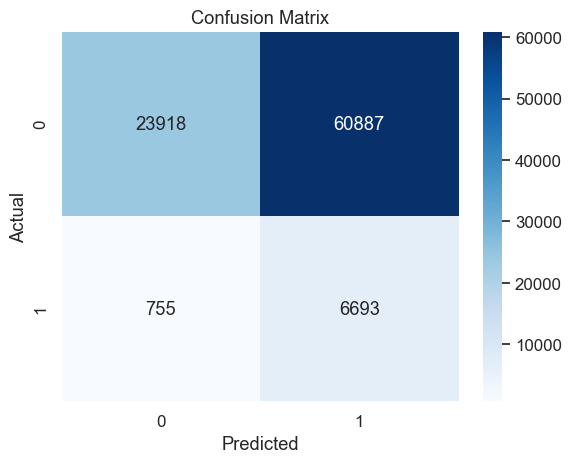


Evaluating with cutoff = 0.5
Cutoff: 0.5
Accuracy: 0.8090
Sensitivity (Recall): 0.4028
Specificity: 0.8447
Precision: 0.1855
F1-Score: 0.2541
ROC AUC: 0.7008


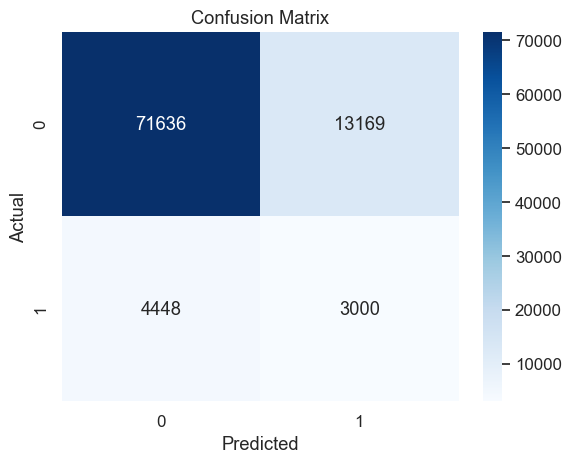


Evaluating with cutoff = 0.7
Cutoff: 0.7
Accuracy: 0.9173
Sensitivity (Recall): 0.0254
Specificity: 0.9957
Precision: 0.3405
F1-Score: 0.0472
ROC AUC: 0.7008


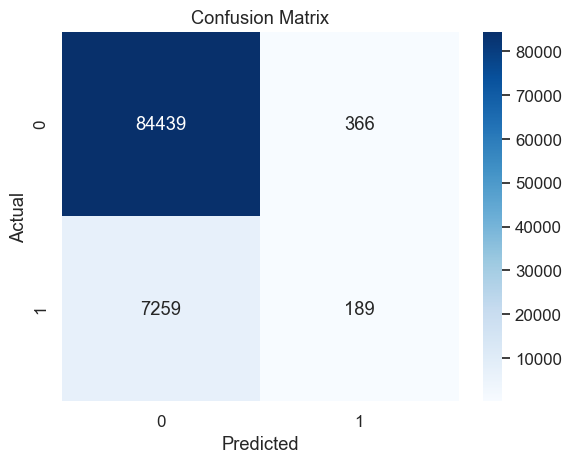

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Separação das variáveis independentes e dependentes
X = df_renomeado.drop(columns=['TARGET'])
y = df_renomeado['TARGET']

# 2) Codificação de variáveis categóricas
X = pd.get_dummies(X)

# 3) Divisão dos dados em treino e teste, com estratificação para garantir a proporção correta das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    train_size=0.7, 
    random_state=42, 
    shuffle=True, 
    stratify=y
)

# 4) Definindo o modelo e os parâmetros para o GridSearchCV
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 5) Definindo o grid de parâmetros para buscar os melhores hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores
    'max_depth': [10, 20, 30],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para divisão
    'min_samples_leaf': [1, 5, 10],  # Número mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2']  # Características a serem consideradas
}

# 6) Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='f1',  # Usar F1-Score como métrica de avaliação principal
    cv=5,  # Validação cruzada com 5 folds
    n_jobs=-1,  # Usar todos os núcleos disponíveis
    verbose=2  # Exibir progresso
)

# 7) Treinamento do modelo com os parâmetros ótimos encontrados pelo GridSearchCV
grid_search.fit(X_train, y_train)

# 8) Exibindo os melhores parâmetros encontrados pelo GridSearchCV
print(f"Melhores parâmetros: {grid_search.best_params_}")

# 9) Avaliação do modelo com os melhores parâmetros
best_rf_clf = grid_search.best_estimator_

# Função para calcular sensibilidade, especificidade, precisão e F1-Score
def calculate_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = recall_score(y_test, y_pred)  # Recall
    specificity = tn / (tn + fp)  # Verdadeiros negativos / Total de negativos
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, sensitivity, specificity, precision, f1, cm

# Função para avaliar o modelo com diferentes cutoffs
def evaluate_model_with_cutoff(clf, X_test, y_test, cutoff=0.5):
    y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1
    y_pred_cutoff = (y_proba >= cutoff).astype(int)  # Ajuste do cutoff

    # Calculando métricas
    accuracy, sensitivity, specificity, precision, f1, cm = calculate_metrics(y_test, y_pred_cutoff)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f'Cutoff: {cutoff}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Testando o modelo com diferentes cutoffs
cutoffs = [0.3, 0.5, 0.7]  # Diferentes valores de cutoff
for cutoff in cutoffs:
    print(f"\nEvaluating with cutoff = {cutoff}")
    evaluate_model_with_cutoff(best_rf_clf, X_test, y_test, cutoff)


## 5.4 - Random Forest - Modelos 02: Base sem Dummies
### 5.4.1 - Random 01


Evaluating with cutoff = 0.3
Cutoff: 0.3
Accuracy: 0.5144
Sensitivity (Recall): 0.7724
Specificity: 0.4918
Precision: 0.1178
F1-Score: 0.2044
ROC AUC: 0.6956


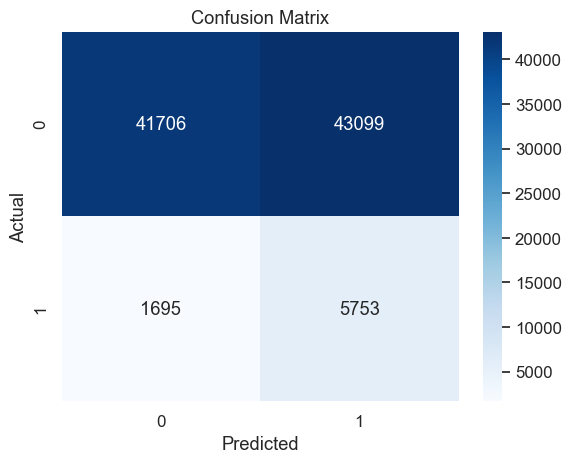


Evaluating with cutoff = 0.5
Cutoff: 0.5
Accuracy: 0.8543
Sensitivity (Recall): 0.2853
Specificity: 0.9043
Precision: 0.2075
F1-Score: 0.2403
ROC AUC: 0.6956


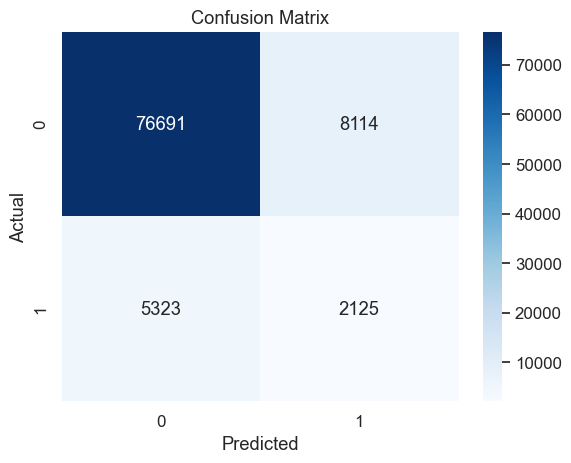


Evaluating with cutoff = 0.7
Cutoff: 0.7
Accuracy: 0.9183
Sensitivity (Recall): 0.0179
Specificity: 0.9974
Precision: 0.3778
F1-Score: 0.0341
ROC AUC: 0.6956


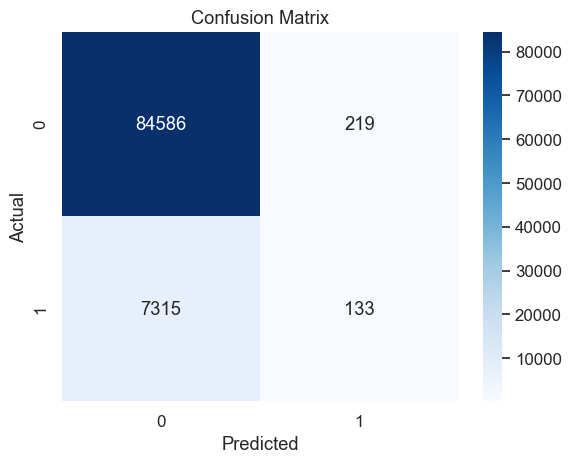

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve, 
    precision_score, recall_score, f1_score
)
from sklearn.tree import plot_tree

# 1. Selecionar colunas e remover variáveis irrelevantes
colunas_selecionadas = [
    'GENERO_F', 'GENERO_M', 'POSSUI_CARRO_N', 'POSSUI_CARRO_S', 
    'POSSUI_IMOVEL_N', 'POSSUI_IMOVEL_S', 'TIPO_CONTRATO_DINH', 'TIPO_CONTRATO_REVOG'
] 

df_dados_sem_dummies = df_renomeado.drop(columns=colunas_selecionadas)

# 2. Separação do conjunto de dados
X = df_dados_sem_dummies.drop(columns=['TARGET'])
y = df_dados_sem_dummies['TARGET']

# Transformar variáveis categóricas em variáveis dummy
X = pd.get_dummies(X)

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42, shuffle=True, stratify=y
)

# 3. Treinamento do modelo Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200, criterion='entropy', max_depth=20, min_samples_split=10,
    min_samples_leaf=5, max_features='sqrt', class_weight='balanced',
    bootstrap=True, random_state=42
)
rf_clf.fit(X_train, y_train)

# 4. Função para calcular métricas e a matriz de confusão
def calculate_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = recall_score(y_test, y_pred)  # Sensibilidade (Recall)
    specificity = tn / (tn + fp)  # Especificidade
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, sensitivity, specificity, precision, f1, cm

# 5. Função para avaliar o modelo com diferentes cutoffs
def evaluate_model_with_cutoff(clf, X_test, y_test, cutoff=0.5):
    y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1
    y_pred_cutoff = (y_proba >= cutoff).astype(int)  # Ajuste do cutoff

    # Calculando métricas
    accuracy, sensitivity, specificity, precision, f1, cm = calculate_metrics(y_test, y_pred_cutoff)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f'Cutoff: {cutoff}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Testando o modelo com diferentes cutoffs
cutoffs = [0.3, 0.5, 0.7]  # Diferentes valores de cutoff
for cutoff in cutoffs:
    print(f"\nEvaluating with cutoff = {cutoff}")
    evaluate_model_with_cutoff(rf_clf, X_test, y_test, cutoff)


### 5.4.2 - Random Forest - Modelos 02: Base sem Dummies com GridSearchCV

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}

Evaluating with cutoff = 0.3
Cutoff: 0.3
Accuracy: 0.3708
Sensitivity (Recall): 0.8790
Specificity: 0.3262
Precision: 0.1028
F1-Score: 0.1841
ROC AUC: 0.6968


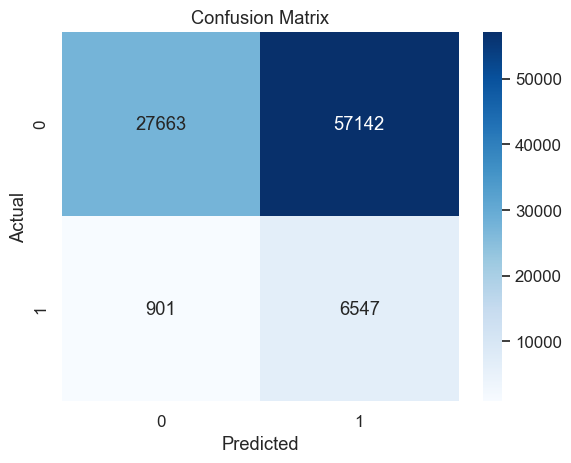


Evaluating with cutoff = 0.5
Cutoff: 0.5
Accuracy: 0.8293
Sensitivity (Recall): 0.3487
Specificity: 0.8715
Precision: 0.1924
F1-Score: 0.2480
ROC AUC: 0.6968


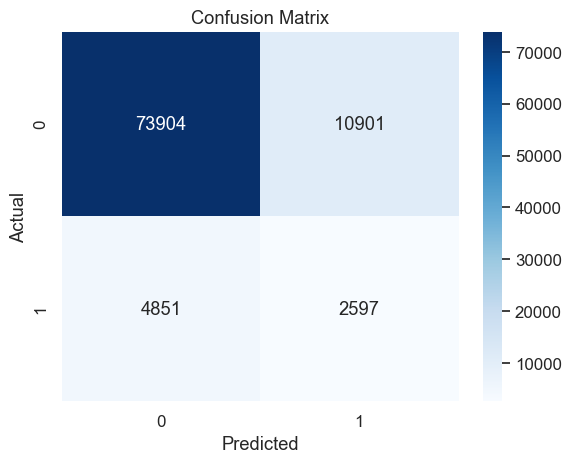


Evaluating with cutoff = 0.7
Cutoff: 0.7
Accuracy: 0.9185
Sensitivity (Recall): 0.0156
Specificity: 0.9978
Precision: 0.3791
F1-Score: 0.0299
ROC AUC: 0.6968


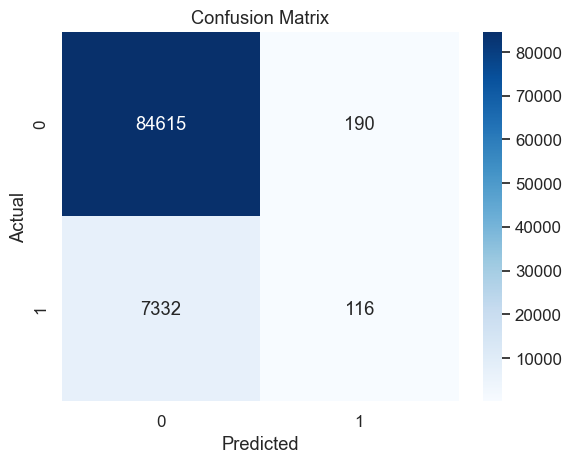

Profundidade máxima da árvore (max_depth): 20
Número mínimo de amostras para dividir um nó (min_samples_split): 2
Número mínimo de amostras em um nó folha (min_samples_leaf): 5
Redução mínima de impureza para dividir um nó (min_impurity_decrease): 0.0


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve, 
    precision_score, recall_score, f1_score
)
from sklearn.tree import plot_tree

# 1. Selecionar colunas e remover variáveis irrelevantes
colunas_selecionadas = [
    'GENERO_F', 'GENERO_M', 'POSSUI_CARRO_N', 'POSSUI_CARRO_S', 
    'POSSUI_IMOVEL_N', 'POSSUI_IMOVEL_S', 'TIPO_CONTRATO_DINH', 'TIPO_CONTRATO_REVOG'
] 

df_dados_sem_dummies = df_renomeado.drop(columns=colunas_selecionadas)

# 2. Separação do conjunto de dados
X = df_dados_sem_dummies.drop(columns=['TARGET'])
y = df_dados_sem_dummies['TARGET']

# Transformar variáveis categóricas em variáveis dummy
X = pd.get_dummies(X)

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size=0.7, random_state=42, shuffle=True, stratify=y
)

# 3. Treinamento do modelo Random Forest com GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', bootstrap=True, random_state=42),
    param_grid=param_grid,
    scoring='f1',  # Pode ajustar para 'accuracy', 'precision', etc.
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Melhor modelo a partir do GridSearch
best_rf_clf = grid_search.best_estimator_
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

# 4. Função para calcular métricas e a matriz de confusão
def calculate_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = recall_score(y_test, y_pred)  # Sensibilidade (Recall)
    specificity = tn / (tn + fp)  # Especificidade
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, sensitivity, specificity, precision, f1, cm

# 5. Função para avaliar o modelo com diferentes cutoffs
def evaluate_model_with_cutoff(clf, X_test, y_test, cutoff=0.5):
    y_proba = clf.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1
    y_pred_cutoff = (y_proba >= cutoff).astype(int)  # Ajuste do cutoff

    # Calculando métricas
    accuracy, sensitivity, specificity, precision, f1, cm = calculate_metrics(y_test, y_pred_cutoff)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f'Cutoff: {cutoff}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Testando o modelo com diferentes cutoffs
cutoffs = [0.3, 0.5, 0.7]  # Diferentes valores de cutoff
for cutoff in cutoffs:
    print(f"\nEvaluating with cutoff = {cutoff}")
    evaluate_model_with_cutoff(best_rf_clf, X_test, y_test, cutoff)

# 7. Exibir os parâmetros do modelo Random Forest
print(f"Profundidade máxima da árvore (max_depth): {best_rf_clf.max_depth}")
print(f"Número mínimo de amostras para dividir um nó (min_samples_split): {best_rf_clf.min_samples_split}")
print(f"Número mínimo de amostras em um nó folha (min_samples_leaf): {best_rf_clf.min_samples_leaf}")
print(f"Redução mínima de impureza para dividir um nó (min_impurity_decrease): {best_rf_clf.min_impurity_decrease}")
